# Symmetry Reduced VQE

The first step is to find the blocks of a Hamiltonian which has have been reduced due to the application of some symmerty consideration.  Each block will then have an associated wavefunction,
$$ |\psi^b> = U(\phi^b_1,\phi^b_1,\ldots)|000\ldots> $$
where $|000\ldots>$ is the state in which $Q$ qubits are in their ground state with $Q$ deterimed by the size of the block $N$ as $Q = \log_2 N$ rounded up and $U$ is a linear transformation with some set of parameters $\{\phi^b_i\}$ which depend on the block.  

For this notebook we will use the linear transformation Anzatz from here: https://arxiv.org/abs/1907.01493.  It gives $U$ as applying y-rotations to each qubit, then coupling each qubit pair with a C-not gate and repreating. 
$$ U^b_i = \prod_q R^y_q(\phi_{q0}^b)\prod_{q'}C_{4q',4q'+1}C_{4q'+3,4q'+2}\prod_{q''}C_{4q''+1,4q''+2}C_{4q''+4,4q''+3} $$
$$ U^b = \prod_i U^b_i $$
where the $\pm$ in the subscripts of the C-not gates alternates (see below for an exact definition).

The Hamiltonian might be block diagonal or it might have some nonzero off diagonal blocks.  In the most general case, the minimization function invovles wave functions from different blocks.  

$$ E = \sum_{a,b}<\psi^a|H_{ab}|\psi^b> $$

To minimize this function we will use the simultaneous perturbation stochastic approximation algorithm.

## Hamiltonian

As an example for this notebook we will use the Hamiltonian generated from Example_Matrix_Creation_Sign_Fix.ipynb

I do not know how to export the summed operator from OpFlow so I will import the numpy matrix and then re-extract the Pauli terms here.

In [368]:
import numpy as np 

#H = np.load('Hamiltonian_Example.npy')
# I have -2.0 < u 2.0 in steps of 0.1
u=10.0
t=-1
H = np.load('H_mu_'+str(u)+"_t_"+str(t)+'.npy')

In [369]:
e,y = np.linalg.eig(H)

np.sort(e)

array([-1.09987777e+00+0.00000000e+00j, -7.95654487e-01+0.00000000e+00j,
       -4.07359506e-01+0.00000000e+00j, -3.85164807e-01+0.00000000e+00j,
       -3.85164807e-01+0.00000000e+00j,  2.03866980e-15+0.00000000e+00j,
        6.85105379e+00+0.00000000e+00j,  7.64670827e+00+0.00000000e+00j,
        8.00000000e+00+0.00000000e+00j,  8.00000000e+00+0.00000000e+00j,
        8.00000000e+00+0.00000000e+00j,  8.00000000e+00+0.00000000e+00j,
        9.30748173e+00+0.00000000e+00j,  9.61483519e+00+0.00000000e+00j,
        9.61483519e+00+0.00000000e+00j,  1.00000000e+01+0.00000000e+00j,
        1.00000000e+01+0.00000000e+00j,  1.00000000e+01+0.00000000e+00j,
        1.00000000e+01+0.00000000e+00j,  1.00000000e+01+0.00000000e+00j,
        1.00000000e+01+0.00000000e+00j,  1.03851648e+01+0.00000000e+00j,
        1.03851648e+01+0.00000000e+00j,  1.06925183e+01+0.00000000e+00j,
        1.20000000e+01+0.00000000e+00j,  1.20000000e+01-1.55088282e-15j,
        1.20000000e+01+1.55088282e-15j,  1.20000000

Now that the Hamiltonian has been imported let us break it into blocks and exctract the Pauli coordinates.  

In [370]:
from qiskit.opflow import (I, X, Y, Z)
from qiskit.opflow.primitive_ops import MatrixOp
from qiskit import quantum_info as qi

# Function to add elements to a block so that it fits onto qubits
def complete_diagonal(b11):
    size = 2**np.ceil(np.log2(len(b11)))
    for v in b11:
        while len(v) < size:
            v.append(0.0)
    while len(b11) < size:
        i = len(b11)
        vnew = [0.0 for i in range(0,8)]
        vnew[i] = 10
        b11.append(vnew)
    return b11

def complete_off_diagonal(b11):
    size = 2**np.ceil(np.log2(len(b11)))
    for v in b11:
        while len(v) < size:
            v.append(0.0)
    while len(b11) < size:
        i = len(b11)
        vnew = [0.0 for i in range(0,8)]
        b11.append(vnew)
    return b11



In [371]:
import math
N = 4
S = 2
bL = math.comb(4,2)

blocks = {}
for bi in range(bL):
    for bj in range(bi,bL):
        bij = [[H[i + bL*bi][j + bL*bj] for j in range(0,bL)] for i in range(0,bL)]
        if np.amax(np.abs(bij)) > 10**(-5):
            if bi == bj:
                bij = complete_diagonal(bij)
            else:
                bij = complete_off_diagonal(bij)
            bij_pauli = MatrixOp(bij).to_pauli_op()
            blocks[str(bi) + ',' + str(bj)] = bij_pauli
        

The object *blocks* is a dictionary of *SumedOp* lists of *PauliOp* objects.  

In [372]:
import pandas as pd

pd.DataFrame(blocks['3,3'].to_matrix())

,0,1,2,3,4,5,6,7
0,10.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j,1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
1,-1.0+0.0j,10.0+0.0j,-1.0+0.0j,-1.0+0.0j,0.0+0.0j,1.0+0.0j,0.0+0.0j,0.0+0.0j
2,0.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
3,0.0+0.0j,-1.0+0.0j,0.0+0.0j,20.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
4,1.0+0.0j,0.0+0.0j,-1.0+0.0j,-1.0+0.0j,10.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j
5,0.0+0.0j,1.0+0.0j,0.0+0.0j,0.0+0.0j,-1.0+0.0j,10.0+0.0j,0.0+0.0j,0.0+0.0j
6,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,10.0+0.0j,0.0+0.0j
7,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,10.0+0.0j


In [373]:
print(blocks['0,0'])

SummedOp([
  10.0 * III,
  -0.5 * IIX,
  2.5 * IIZ,
  -0.25 * IXI,
  -0.25 * IXX,
  0.25 * IXZ,
  -0.25 * IYY,
  -0.5 * IZX,
  2.5 * IZZ,
  0.5 * XII,
  -0.25 * XXI,
  -0.25 * XXX,
  -0.25 * XXZ,
  0.25 * XYY,
  0.5 * XZI,
  -0.25 * YXY,
  -0.25 * YYI,
  -0.25 * YYX,
  -0.25 * YYZ,
  2.5 * ZII,
  -0.25 * ZXI,
  -0.25 * ZXX,
  0.25 * ZXZ,
  -0.25 * ZYY,
  2.5 * ZZI
])


Let's take a sanity check here and make sure we can rebuild a Hamiltonian with these completed blocks and that the ground state is still the same.

In [374]:
keys = list(blocks.keys())

size = int(2**np.ceil(np.log2(bL)))
H_complete = np.array([[0 for i in range(size*bL)] for j in range(size*bL)])

for bi in range(bL):
    for bj in range(bi,bL):
        key = str(bi) + ',' + str(bj)
        if key  in keys:
            block = blocks[key].to_matrix()
        else:
            block = np.array([[0.0 for i in range(size)] for j in range(size)])
        for i in range(size):
            for j in range(size):
                H_complete[i + bi*size, j + bj*size] = block[i,j]
                H_complete[i + bj*size, j + bi*size] = block[j,i]
                

<ipython-input-374-4f4400865c4e>:15: ComplexWarning: Casting complex values to real discards the imaginary part
  H_complete[i + bi*size, j + bj*size] = block[i,j]
<ipython-input-374-4f4400865c4e>:16: ComplexWarning: Casting complex values to real discards the imaginary part
  H_complete[i + bj*size, j + bi*size] = block[j,i]


In [375]:
pd.set_option("display.max_rows", 15, "display.max_columns", 15)
pd.DataFrame(H_complete)

,0,1,2,3,4,5,6,...,41,42,43,44,45,46,47
0,20,-1,0,0,1,0,0,...,0,0,0,0,0,0,0
1,-1,10,-1,-1,0,1,0,...,0,0,0,0,0,0,0
2,0,-1,10,0,-1,0,0,...,0,0,0,0,0,0,0
3,0,-1,0,10,-1,0,0,...,0,0,0,0,0,0,0
4,1,0,-1,-1,10,-1,0,...,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43,0,0,0,0,0,0,0,...,-1,0,10,-1,0,0,0
44,0,0,0,0,0,0,0,...,0,-1,-1,10,-1,0,0
45,0,0,0,0,0,0,0,...,1,0,0,-1,20,0,0
46,0,0,0,0,0,0,0,...,0,0,0,0,0,10,0


In [376]:
e_comp,y_comp = np.linalg.eig(H_complete)

print(np.sort(e_comp)[0])
print(np.sort(e)[0])

-1.0998777727497349
(-1.099877772749744+0j)


## The Anzatz circuit

Here we define the paramaterized circuit which we will optimize. 

$$ U^b_i = \prod_q R^y_q(\phi_{q0}^b)\prod_{q'}C_{4q',4q'+1}C_{4q'+3,4q'+2}\prod_{q''}C_{4q''+1,4q''+2}C_{4q''+4,4q''+3} $$
$$ U^b = \prod_i U^b_i $$

In [377]:
from qiskit import QuantumCircuit, QuantumRegister,ClassicalRegister, execute


# the number of qubits is given by the size of the blocks
# note: the size of the blocks has already been adjusted to fit the qubits
Q = int(np.log2(len(blocks['0,0'].to_matrix())))


In [378]:
def Ui(cir_i,phi_i):  
    
    for q in range(0,Q):
        cir_i.ry(phi_i[q],q)
    for q in range(0,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    for q in range(1,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    
    return cir_i


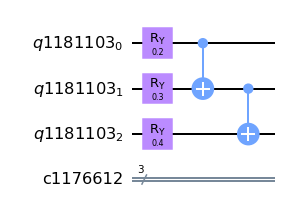

In [379]:
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir_i = QuantumCircuit(qr , cr)
tst = Ui(cir_i,[0.2,0.3,0.4])

tst.draw(output = 'mpl')

In [380]:
def U(cir,phi_b):
    T = len(phi_b)
    for t in range(T):
        cir = Ui(cir,phi_b[t])
    return cir


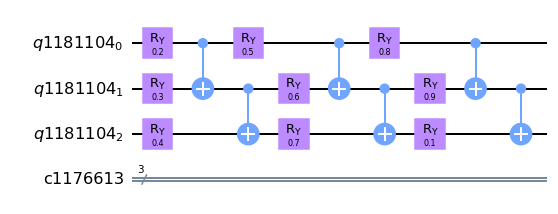

In [381]:
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
tst = U(cir,[[0.2,0.3,0.4],[0.5,0.6,0.7],[0.8,0.9,0.1]])

tst.draw(output = 'mpl')

In order to deal with off diagonal blocks, we will also need to form $$ U^{ab} = I\otimes U^a + X \otimes U^b$$

In order to create this gate we need a controled-Ry gate.  The controled-Ry can be built as $C_{R_y}(\phi) = R_y(\phi/2)C_{NOT}R_y(-\phi/2)C_{NOT}$

In [382]:
def Ui_off(cir_i,phi_a, phi_b):  
    
    for q in range(0,Q):
        cir_i.ry(phi_a[q],q)
        cir_i.cx(Q,q)
        cir_i.ry(-(phi_b[q]-phi_a[q])/2,q)
        cir_i.cx(Q,q)
        cir_i.ry((phi_b[q]-phi_a[q])/2,q)
    for q in range(0,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    for q in range(1,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    
    return cir_i

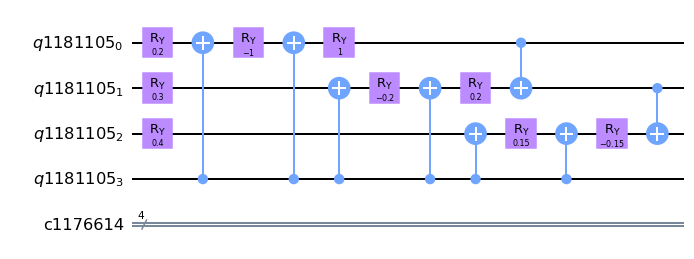

In [383]:
qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir_i = QuantumCircuit(qr , cr)
tst = Ui_off(cir_i,[0.2,0.3,0.4],[2.2,0.7,0.1])

tst.draw(output = 'mpl')

Let's check to make sure we are generating the right thing

In [384]:
#An example block a circuit
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir_i = QuantumCircuit(qr , cr)
tst_a = Ui(cir_i,[0.2,0.3,0.4])

#An example block b circuit
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir_i = QuantumCircuit(qr , cr)
tst_b = Ui(cir_i,[2.2,0.7,0.1])

#The combination of the two blocks
qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir_i = QuantumCircuit(qr , cr)
cir_i.h(Q)
tst_off = Ui_off(cir_i,[0.2,0.3,0.4],[2.2,0.7,0.1])

print('A:')
print(1/np.sqrt(2)*qi.Statevector.from_instruction(tst_a).data)
print('B:')
print(1/np.sqrt(2)*qi.Statevector.from_instruction(tst_b).data)
print('AB:')
print(qi.Statevector.from_instruction(tst_off).data)

A:
[0.68180665+0.j 0.01033899+0.j 0.02088826+0.j 0.01386716+0.j
 0.13820905+0.j 0.00209582+0.j 0.103045  +0.j 0.06840885+0.j]
B:
[0.3009187 +0.j 0.21581687+0.j 0.00549678+0.j 0.02958631+0.j
 0.01505849+0.j 0.01079984+0.j 0.1098439 +0.j 0.59123293+0.j]
AB:
[0.68180665+0.j 0.01033899+0.j 0.02088826+0.j 0.01386716+0.j
 0.13820905+0.j 0.00209582+0.j 0.103045  +0.j 0.06840885+0.j
 0.3009187 +0.j 0.21581687+0.j 0.00549678+0.j 0.02958631+0.j
 0.01505849+0.j 0.01079984+0.j 0.1098439 +0.j 0.59123293+0.j]


In [385]:
def U_off(cir,phi_a,phi_b):
    T = len(phi_b)
    cir.h(Q)
    for t in range(T):
        cir = Ui_off(cir,phi_a[t],phi_b[t])
    return cir

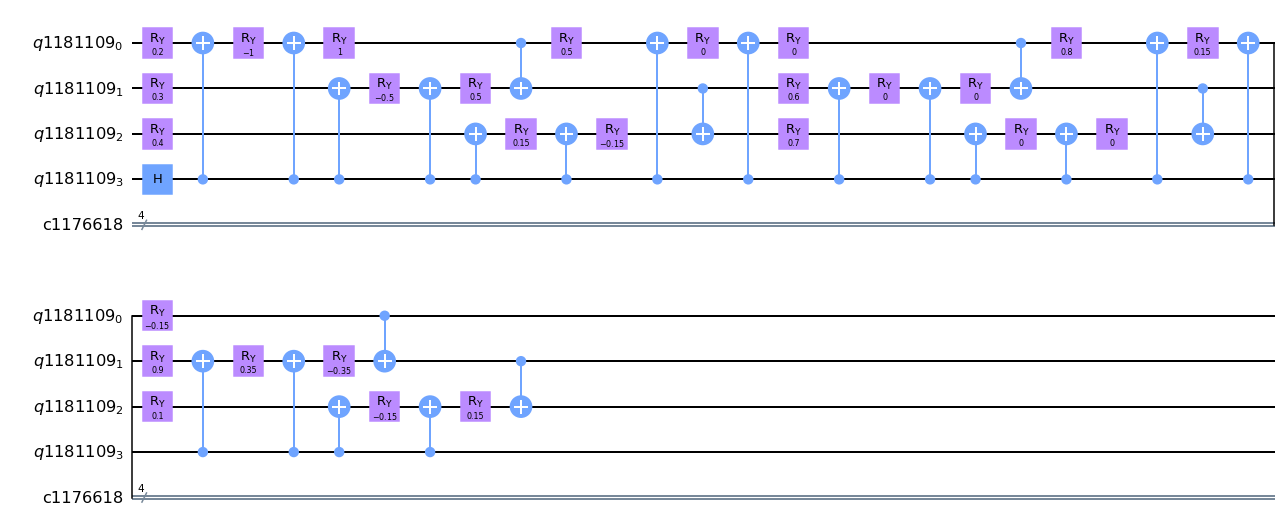

In [386]:
qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir = QuantumCircuit(qr , cr)
tst = U_off(cir,[[0.2,0.3,0.4],[0.5,0.6,0.7],[0.8,0.9,0.1]],[[2.2,1.3,0.1],[0.5,0.6,0.7],[0.5,0.2,0.4]])

tst.draw(output = 'mpl')

# Calculating E

$$ E = \sum_{ab}<\psi^a|H_{ab}|\psi^b> = \sum_{ab}<000\ldots|U^{\dagger}(\{\phi^a\})H_{ab}U(\{\phi^b\})|000\ldots>$$

each $H_{ab}$ can be brocken down into its Puali components so that $H_{ab} = \sum_p c_p P_{ab,p}$.  Then we have

$$ E = \sum_{ab}\sum_p c_p <000\ldots|U^{\dagger}(\{\phi^a\})  P_{ab,p}U(\{\phi^b\})|000\ldots>$$.

We cannot measure $<\psi^a|P_{ab,p}|\psi^b>$ directly.  Instead we measure $|<\psi^a|P_{ab,p}|\psi^b>|^2$ which tells us nothing about the sign.  


To fix the issue we need to find a way to use the counts to recreate the desired measurement.  This can be done by looking at the counts in each occupation state. 

First we need to go through the circuit and add a $R_y(-\pi/2)$ gate on each qubit where $P_{ab,p}$ applies an X and an $R_x(\pi/2)$ gate to each qubit where $P_{ab,p}$ applies an Y.  This rotates all of the Pauli terms to Z.   Then we can take the count for each occupation state mulitply that count by $(-1)^n$ where n is the number of up qubits with a Puali term in $P_{ab,p}$. 

for example:

\begin{equation}
\begin{split}
<\psi|XZ|\psi> &= <(R_y(\pi/2)\otimes I)\psi|R^{\dagger}_y(\pi/2)XR_y(\pi/2)\otimes Z|(R^{\dagger}_y(\pi/2)\otimes I)\psi>
\\
& = <(R_y(\pi/2)\otimes I)\psi|ZZ|(R^{\dagger}_y(\pi/2)\otimes I)\psi>
\\
& = |<00|R^{\dagger}_y(\pi/2)\psi>|^2 + (-1)^1|<10|R^{\dagger}_y(\pi/2) \psi>|^2 + (-1)^1|<01|R^{\dagger}_y(\pi/2) \psi>|^2 + (-1)^2|<11|R^{\dagger}_y(\pi/2) \psi>|^2
\end{split}
\end{equation}

This unfortunetly does not work for $|\psi^a> \neq |\psi_b>$



In [387]:
from qiskit import Aer
from qiskit.visualization import *
from qiskit import quantum_info as qi

def measure_pauli(p_label,psi0,method = 'simple'):
    
    #Simple method of calculation####
    if method == 'simple':
        wave0 = qi.Statevector.from_instruction(psi0)
        Op = qi.Operator.from_label(p_label)
        return np.dot(np.conjugate(wave0),np.dot(Op,wave0))
    #################################
        
    #apply rotations#################
    psi = copy.deepcopy(psi0)
    pauli_qs = []
    Z_label = ''
    Q = len(p_label)
    for q,p in enumerate(p_label):
        if p == 'X':
            psi.ry(-np.pi/2,Q-1-q)
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'Y':
            psi.rx(np.pi/2,Q-1-q)
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'Z':
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'I':
            pauli_qs.append(0)
            Z_label += 'I'
    ################################
    
    #Using matrix multiplication####
    if method == 'matrix':
        # add results
        wave = qi.Statevector.from_instruction(psi)
        r = wave.probabilities_dict()
        z_measure = 0
        for key in list(r.keys()):
            n = 0
            for q in range(len(key)):
                if key[q] == '1' and pauli_qs[q] == 1:
                    n += 1
            z_measure += (-1)**n * r[key] 
        return z_measure
    #################################
    
    #Using the qasm simulator########
    if method == "simulator":
        sim = Aer.get_backend("qasm_simulator")
        psi.measure(psi.qubits,psi.clbits)
        r = execute(psi, backend = sim).result().get_counts()
        z_measure = 0
        total = 0
        for key in list(r.keys()):
            n = 0
            for q in range(len(key)):
                if key[q] == '1' and pauli_qs[q] == 1:
                    n += 1
            z_measure += (-1)**n * r[key] 
            total += r[key]
        return z_measure/total
    ###################################
    
    raise NameError(method + ' is not a recognized method')
    return method + ' is not a recognized method'
  

#Run a test
import copy
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi0 = U(cir,[[1.2,2.3,3.4]])
p_label = blocks['0,0'][17].primitive.to_label()
        
    
print( measure_pauli(p_label,psi0,method = 'simple') )
print( measure_pauli(p_label,psi0,method = 'matrix') )
print( measure_pauli(p_label,psi0,method = 'simulator') )
#print( measure_pauli(p_label,psi0,method = 'Moon_Cheese') )

(0.9010937037265272+0j)
0.9010937037265271
0.912109375


In order to calculate things like 
$$<\psi^a|ZZ|\psi^b>$$ 
we will need to add another qubit and build the combined statevector 
$$ |\psi^{ab}> = |0>|\psi^a> + |1>|\psi_b> $$
then we can calculate
$$ <\psi^{ab}|X\otimes ZZ|\psi^{ab}> = <\psi^{ab}|\left(|1>ZZ|\psi^a> + |0>ZZ|\psi_b> \right) = <\psi^{a}|ZZ|\psi^{b}> + <\psi^{b}|ZZ|\psi^{a}>  $$ 

In order to form the combined statevector we need to create a circuit which performs 
$$ U^{ab} = I\otimes U^a + X \otimes U^b$$
This as done in the Ansatz section.   Here we will use that result to calculate E.

In [388]:
import random

alpha = 1/np.sqrt(bL)*np.array([1 for b in range(bL)])

#number of blocks
T = 1
phi = []
for b in range(bL):
    phi_b = []
    for ti in range(T):
        phi_t = []
        for q in range(Q):
            rand = random.random()
            phi_t.append(rand)
        phi_b.append(phi_t)
    phi.append(phi_b)

#Find the energy contribution from on diagonal blocks
def E_on_block(phi_b,block,method = 'simple'):
    E = 0
    qr = QuantumRegister(Q)
    cr = ClassicalRegister(Q)
    cir = QuantumCircuit(qr , cr)
    psi0 = U(cir,phi_b)
    for p in block:
        psi = copy.deepcopy(psi0)
        w = p.coeff
        p_label = p.primitive.to_label()
        E_p = measure_pauli( p_label,psi,method = method)
        E += w*E_p
    return E
        
        
block = blocks['0,0']
phi_b = phi[0]

M_b = block.to_matrix()
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi0 = U(cir,phi_b)
wave = qi.Statevector.from_instruction(psi0).data
print('check:',np.dot(np.conjugate(wave),np.dot(M_b,wave)))

print('simple:',E_on_block(phi_b,block,method = 'simple'))
print('matrix:',E_on_block(phi_b,block,method = 'matrix'))
print('simulator:',E_on_block(phi_b,block,method = 'simulator'))
#print('mooncheese:',E_on_block(phi_b,block,method = 'mooncheese'))

check: (19.014947493539587+0j)
simple: (19.01494749353959+0j)
matrix: 19.01494749353959
simulator: 18.88330078125


In [389]:
# Find the energy contribution from off diagonal blocks
def E_off_block(phi_a,phi_b,block,method = 'simple'):
    E = 0
    qr = QuantumRegister(Q+1)
    cr = ClassicalRegister(Q+1)
    cir = QuantumCircuit(qr , cr)
    psi0 = U_off(cir,phi_a,phi_b)
    for p in block:
        psi = copy.deepcopy(psi0)
        w = p.coeff
        p_label = p.primitive.to_label()
        E_p = measure_pauli('X' + p_label,psi,method = method)
        E += w*E_p
    return E

block = blocks['0,1']
phi_a = phi[0]
phi_b = phi[1]
M_b = block.to_matrix()
#A
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi_a = U(cir,phi_a)
wave_a = qi.Statevector.from_instruction(psi_a).data
#B
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi_b = U(cir,phi_b)
wave_b = qi.Statevector.from_instruction(psi_b).data
print('check:',np.dot(np.conjugate(wave_a),np.dot(M_b,wave_b)))

print('simple:',E_off_block(phi_a,phi_b,block,method = 'simple'))
print('matrix:',E_off_block(phi_a,phi_b,block,method = 'matrix'))
print('simulator:',E_off_block(phi_a,phi_b,block,method = 'simulator'))
#print('mooncheese:',E_off_block(phi_a,phi_b,block,method = 'mooncheese'))

check: (-0.8891610615249382+0j)
simple: (-0.8891610615249388+0j)
matrix: -0.8891610615249388
simulator: -0.88916015625


Now we need to add all of the blocks together

In [390]:
# The total energy 
def find_E(alpha,phi,blocks,method = 'simple'):
    E = 0
    for key in list(blocks.keys()):
        if key[0] == key[2]:
            E += alpha[int(key[0])]*alpha[int(key[2])]*E_on_block(phi[int(key[0])],blocks[key],method = 'simple')
        else:
            E += 2*alpha[int(key[0])]*alpha[int(key[2])]*E_off_block(phi[int(key[0])],phi[int(key[2])],blocks[key],method = 'simple')
    return E
            
find_E(alpha,phi,blocks)

(8.710504781133812+0j)

In [391]:
#Check against H_complete               
wave_full = []
for b in range(bL):
    qr = QuantumRegister(Q)
    cr = ClassicalRegister(Q)
    cir = QuantumCircuit(qr , cr)
    psi_b = U(cir,phi[b])
    wave_b = alpha[b]*qi.Statevector.from_instruction(psi_b).data
    wave_full.append(wave_b)
wave_full = np.array(wave_full).flatten()

np.dot(np.conjugate(wave_full),np.dot(H_complete,wave_full))


(8.71050478113381+0j)

First we need to inialize our set of parameters.  To do this we need to decide on the number of times we will apply Ui.  As a first attempt let's just have a depth of 1 (i.e. $U = Ui$).  

In this case, we need a parameter for each qubit for each section.

In [392]:
alpha = 1/np.sqrt(bL)*np.array([1 for b in range(bL)])

#number of blocks
T = 2
phi = []
for b in range(bL):
    phi_b = []
    for ti in range(T):
        phi_t = []
        for q in range(Q):
            phi_t.append(0)
        phi_b.append(phi_t)
    phi.append(phi_b)
    
find_E(alpha,phi,blocks)

(8.66666666666667+0j)

The structure of $\phi_{b,t,q}$ is by section in the first index, by number of application of $U_i$ in the second index, and by qubit in the third index


# Optimization

I will be using the simultaneous perturbation stochastic approximation algorithm.  The algorithm works by calculating the gradiant of the cost function $E(\hat{\phi})$ by randomly purturbating all parameters in $\hat{\phi}$

Let $\hat{\Delta}_k$ be a set of randomly selected purturbations during step $k$ of the algorithm. I will use the Bernoulli distribution to select $\hat{\Delta}_k$.  Then the gradient is 
$$ \hat{g}_k(\hat{\phi}_k) = \frac{E(\hat{\phi}_k + c_k \hat{\Delta}_k)-E(\hat{\phi}_k - c_k \hat{\Delta}_k)}{2 c_k} \hat{\Delta}_k$$.
The gradiant is then used to update the parameters 
$$ \hat{\phi}_{k+1} = \hat{\phi}_k - a_k \hat{g}_k(\hat{\phi}_k) $$

$c_k$ and $a_k$ decrease with each iteration of the algorithm so that we zero in on the the minimum of $E$.  They are given by
$$c_k = \frac{c}{(k+1)^{\gamma}}$$
$$a_k = \frac{a}{(A+k+1)^{\alpha}}$$
where $a$, $A$, $\alpha$, $c$, and $\gamma$ are choosen at the begining of the algorithm.

In [393]:
import copy

In [394]:
#beta = 0.602
beta = 0.201
A = 10
a = 0.05
gamma = 0.101
c = 0.4

beta_a = 0.201
A_a = 10
a_a = 0.05
gamma_a = 0.101
c_a = 0.4

def SPSA(k_max,method = 'simple',hold = False):
    #Initalization
    k = 0
    phi_k = np.array(phi)
    alpha_k = np.array(alpha)
    E_l = []
    hold_l = []
    
    #Begin Iterations
    for k in range(k_max):
        #Update c and a
        a_k = a/((A + k + 1)**beta)
        c_k = c/((k + 1)**gamma)
        a_ak = a_a/((A_a + k + 1)**beta_a)
        c_ak = c_a/((k + 1)**gamma_a)

        #Find Delta
        Delta_k = np.array(phi_k)
        for b in range(bL):
            for t in range(T):
                for q in range(Q):
                    Delta_k[b][t][q] = 1 - 2*np.random.binomial(size=None, n=1, p= 0.5)
        phi_k_A = phi_k + c_k*Delta_k
        phi_k_B = phi_k - c_k*Delta_k
        
        #Find Delta Alpha
        Delta_ak = np.array(alpha_k)
        for n in range(bL):
            Delta_ak[n] = 1 - 2*np.random.binomial(size=None, n=1, p= 0.5)
        alpha_k_A = alpha_k + c_ak*Delta_ak
        alpha_k_B = alpha_k - c_ak*Delta_ak
        norm_A = 1/np.sqrt(np.dot(alpha_k_A,alpha_k_A))
        norm_B = 1/np.sqrt(np.dot(alpha_k_B,alpha_k_B))
        alpha_k_A = norm_A*alpha_k_A
        alpha_k_B = norm_B*alpha_k_B
            
        #Find E    
        E_A = find_E(alpha_k_A, phi_k_A, blocks, method = method)
        E_B = find_E(alpha_k_B, phi_k_B, blocks, method = method)
        
        #Calculate gradiant
        g = np.real((E_A-E_B)/(2*c_k)) 
        
        #Update phi
        g_k = g * Delta_k
        phi_k = phi_k - a_k * g_k
        
        #Update alpha
        g_ak = g * Delta_ak
        alpha_k = alpha_k - a_ak * g_ak
        norm = 1/np.sqrt(np.dot(alpha_k,alpha_k))
        alpha_k = norm*alpha_k

        
        #Calculate new E
        E_f = np.real(find_E(alpha_k,phi_k,blocks, method = method))
        
        #Print and save E
        print('k=',k,'c_k=',c_k,'a_k=',a_k,'g=',g,'E_A=',E_A,'E_B=',E_B,'E_f=',E_f)
        E_l.append(E_f)
        
        if hold == True:
            hold_k = {'E':E_f,'c':c_k,'a':a_k,'phi':phi_k,'Delta':Delta_k,'c_a':c_ak,'a_a':a_ak,'alpha':alpha_k,'Delta_a':Delta_ak}
            hold_l.append(hold_k)
    if hold == True:
        return hold_l
    else:
        return E_l,phi_k

In [395]:
out = SPSA(3000,method = 'simple',hold = True)

k= 0 c_k= 0.4 a_k= 0.030878064824598282 g= 0.3256513461098942 E_A= (9.911995683716038+0j) E_B= (9.651474606828122+0j) E_f= 8.643129130380805
k= 1 c_k= 0.372954594574733 a_k= 0.030342724499598534 g= 0.1671479952715257 E_A= (9.91464712816662+0j) E_B= (9.789969902545678+0j) E_f= 8.633601410564701
k= 2 c_k= 0.3579898757427053 a_k= 0.029858459038837503 g= 1.3790414597698573 E_A= (9.502012093021278+0j) E_B= (8.514646331367178+0j) E_f= 8.571218891821346
k= 3 c_k= 0.34773782403600867 a_k= 0.029416992458941946 g= -1.770318769238448 E_A= (8.61245095326419+0j) E_B= (9.843664546594356+0j) E_f= 8.43211227827485
k= 4 c_k= 0.33998833831625347 a_k= 0.02901186589249766 g= 0.2986459018686013 E_A= (9.474042003621207+0j) E_B= (9.270969755778678+0j) E_f= 8.423034048536897
k= 5 c_k= 0.3337849224236992 a_k= 0.028637947449493925 g= 5.947336077342648 E_A= (11.427994011374555+0j) E_B= (7.457731788967588+0j) E_f= 7.153332526512326
k= 6 c_k= 0.32862839767254015 a_k= 0.028291095918097278 g= 2.10754344671934 E_A= (

k= 53 c_k= 0.26735494522142605 a_k= 0.021673439087867164 g= 0.6481983552336238 E_A= (4.771987957960753+0j) E_B= (4.425389886448545+0j) E_f= 1.513822318442942
k= 54 c_k= 0.2668599250350944 a_k= 0.02160600238280336 g= -8.994306692813309 E_A= (2.4354111155715072+0j) E_B= (7.235851135145122+0j) E_f= 1.7054541099141625
k= 55 c_k= 0.26637471655715955 a_k= 0.021539800337028216 g= -3.1455598037545673 E_A= (3.612567446314179+0j) E_B= (5.2883626485916135+0j) E_f= 1.1353578675260145
k= 56 c_k= 0.2658989552298248 a_k= 0.02147479214577462 g= 3.7023452753766657 E_A= (5.713296724380935+0j) E_B= (3.7443972431354684+0j) E_f= 1.5973330141654178
k= 57 c_k= 0.26543229614067565 a_k= 0.021410938936572577 g= 2.6578862336094775 E_A= (5.820058745386586+0j) E_B= (4.409081053651274+0j) E_f= 1.8485690569652675
k= 58 c_k= 0.26497441264651617 a_k= 0.02134820365090901 g= -8.62046861799647 E_A= (3.1105077551245497+0j) E_B= (7.678914972707229+0j) E_f= 2.1784305543836893
k= 59 c_k= 0.2645249951151027 a_k= 0.02128655093

k= 105 c_k= 0.24974919607452548 a_k= 0.01923153495014902 g= -4.937510475137542 E_A= (2.647755075333923+0j) E_B= (5.114033618884222+0j) E_f= 1.7638082061337321
k= 106 c_k= 0.2495124552599996 a_k= 0.01919838276571559 g= -10.424519278509743 E_A= (1.2677573781997382+0j) E_B= (6.469852178372069+0j) E_f= 0.9821239594269544
k= 107 c_k= 0.24927813800651724 a_k= 0.019165569152951475 g= -2.4060638102236878 E_A= (3.4296800527421683+0j) E_B= (4.629238265817023+0j) E_f= 0.960526955942766
k= 108 c_k= 0.24904619740500722 a_k= 0.01913308782851349 g= -6.9507143946950425 E_A= (2.130164106595405+0j) E_B= (5.592262085089499+0j) E_f= 1.1846595984817532
k= 109 c_k= 0.24881658787426822 a_k= 0.019100932677229843 g= -1.7716413136363542 E_A= (3.157299188752752+0j) E_B= (4.03892668194492+0j) E_f= 1.2754398422896738
k= 110 c_k= 0.24858926511170829 a_k= 0.019069097746241874 g= 1.1566297708422155 E_A= (3.8206690688511458+0j) E_B= (3.245617579371166+0j) E_f= 1.1627548567849197
k= 111 c_k= 0.24836418604633714 a_k= 0.

k= 157 c_k= 0.23988087567680955 a_k= 0.017851833955768864 g= 0.6990357989365393 E_A= (2.812623407293547+0j) E_B= (2.477252768136877+0j) E_f= 0.560184679727421
k= 158 c_k= 0.239728066017013 a_k= 0.01783055152347874 g= 3.9450238758613247 E_A= (3.9083222461756804+0j) E_B= (2.016856357873328+0j) E_f= 0.5819597901947967
k= 159 c_k= 0.23957631084767136 a_k= 0.01780941980024826 g= -1.7823284045320809 E_A= (2.549141557472903+0j) E_B= (3.403148885226527+0j) E_f= 0.6877094364503282
k= 160 c_k= 0.2394255963693599 a_k= 0.01778843684169224 g= 0.6684562157197279 E_A= (2.904619106439419+0j) E_B= (2.5845280502484163+0j) E_f= 0.7204549079526568
k= 161 c_k= 0.23927590904754018 a_k= 0.017767600739695997 g= -0.42659028030781365 E_A= (3.089743212646287+0j) E_B= (3.2938887668692813+0j) E_f= 0.7448548322728699
k= 162 c_k= 0.2391272356058773 a_k= 0.017746909621532535 g= -3.215376059815468 E_A= (2.3326392639953584+0j) E_B= (3.87040724122934+0j) E_f= 0.4050894137215594
k= 163 c_k= 0.23897956301976508 a_k= 0.017

k= 209 c_k= 0.23308581407379206 a_k= 0.016909978113415238 g= 6.129200089559584 E_A= (5.489657325689317+0j) E_B= (2.632398140697007+0j) E_f= 1.4286967768853942
k= 210 c_k= 0.232974003790588 a_k= 0.01689457057268661 g= -1.0403877121409761 E_A= (3.7598286080539474+0j) E_B= (4.244595189637973+0j) E_f= 1.4738100623390367
k= 211 c_k= 0.23286277541835038 a_k= 0.016879246535884136 g= -0.8867041581347542 E_A= (3.5923609165053465+0j) E_B= (4.005321698981848+0j) E_f= 1.4303648090072967
k= 212 c_k= 0.23275212320502842 a_k= 0.016864005177345095 g= -4.393047502568547 E_A= (2.705974726911827+0j) E_B= (4.750956994038581+0j) E_f= 1.4544156631466174
k= 213 c_k= 0.23264204148209838 a_k= 0.01684884568322677 g= -6.18084680064416 E_A= (2.2813952514963116+0j) E_B= (5.157244887076219+0j) E_f= 1.3256513412995494
k= 214 c_k= 0.23253252466296698 a_k= 0.01683376725128538 g= -2.3115467191715346 E_A= (2.6868053577080513+0j) E_B= (3.761824946678762+0j) E_f= 1.324536188592173
k= 215 c_k= 0.23242356724141247 a_k= 0.01

k= 261 c_k= 0.22793528529233112 a_k= 0.016203978363821238 g= 1.6128713915315311 E_A= (3.42837215664159+0j) E_B= (2.6931115551044327+0j) E_f= 0.7946225229312035
k= 262 c_k= 0.22784760124157974 a_k= 0.016192030465129542 g= -3.562310298168145 E_A= (2.3587370232495424+0j) E_B= (3.9820647358811194+0j) E_f= 0.8987143080668383
k= 263 c_k= 0.22776028349769972 a_k= 0.016180135013178557 g= 1.851254483257909 E_A= (3.324483977824887+0j) E_B= (2.481199485958469+0j) E_f= 0.972527181161825
k= 264 c_k= 0.22767332915155544 a_k= 0.016168291587591768 g= -0.4686236949380624 E_A= (2.887763473613945+0j) E_B= (3.101149707105648+0j) E_f= 0.9942640607832778
k= 265 c_k= 0.22758673532798307 a_k= 0.01615649977287518 g= 2.209408968902765 E_A= (3.613484379537206+0j) E_B= (2.607820031063315+0j) E_f= 1.013500600400982
k= 266 c_k= 0.22750049918526816 a_k= 0.01614475915834319 g= -0.5309121823943418 E_A= (3.078664818600476+0j) E_B= (3.320230391636982+0j) E_f= 1.0400595522574014
k= 267 c_k= 0.22741461791463288 a_k= 0.016

k= 313 c_k= 0.2238051608099392 a_k= 0.01564409545779878 g= 0.4150618521397518 E_A= (2.9548268575332193+0j) E_B= (2.7690408884048026+0j) E_f= 0.6787859702156677
k= 314 c_k= 0.22373329845369114 a_k= 0.01563440827132114 g= -2.658513710957276 E_A= (2.24039890226427+0j) E_B= (3.429994985337938+0j) E_f= 0.4835659434267563
k= 315 c_k= 0.22366168683569107 a_k= 0.015624756816751385 g= -5.026797932151275 E_A= (1.925874579758753+0j) E_B= (4.174478789532989+0j) E_f= 0.4479134055410807
k= 316 c_k= 0.2235903242917423 a_k= 0.01561514085328741 g= -3.4020196092118695 E_A= (1.8635784642741402+0j) E_B= (3.384895799615237+0j) E_f= 0.4400568619065917
k= 317 c_k= 0.22351920917389975 a_k= 0.015605560142480006 g= 4.66918757047488 E_A= (3.593000956839898+0j) E_B= (1.5056947303656032+0j) E_f= 0.42212951457609993
k= 318 c_k= 0.22344833985026066 a_k= 0.01559601444820278 g= 2.221619403395484 E_A= (3.3041408215260875+0j) E_B= (2.3113064865903925+0j) E_f= 0.49287976295270186
k= 319 c_k= 0.22337771470475873 a_k= 0.01

k= 364 c_k= 0.22042883838719754 a_k= 0.015191117381045689 g= -0.8505059144978503 E_A= (2.4784195430224+0j) E_B= (2.8533716045708046+0j) E_f= 0.4552614010309556
k= 365 c_k= 0.2203679348282601 a_k= 0.015182987955433009 g= -6.797355566825754 E_A= (1.7673296340196858+0j) E_B= (4.763168051129223+0j) E_f= 0.5011101683672505
k= 366 c_k= 0.22030721420427177 a_k= 0.015174884455038869 g= -1.5866445336715571 E_A= (2.6153357139994258+0j) E_B= (3.314434188290659+0j) E_f= 0.5908194658652753
k= 367 c_k= 0.22024667546953405 a_k= 0.015166806728747234 g= -1.7904239445731642 E_A= (2.94515698915492+0j) E_B= (3.7338268321014976+0j) E_f= 0.6276085870760516
k= 368 c_k= 0.22018631758714713 a_k= 0.015158754626719726 g= -8.148596683369986 E_A= (0.6027400560507107+0j) E_B= (4.191159050478865+0j) E_f= 0.18879279126371945
k= 369 c_k= 0.220126139528912 a_k= 0.01515072800038149 g= 0.6487966588272244 E_A= (2.5971505395503915+0j) E_B= (2.3115163318566045+0j) E_f= 0.21326009940794516
k= 370 c_k= 0.22006614027523438 a_k

k= 415 c_k= 0.2175362135656255 a_k= 0.014806713559895953 g= -0.43168859070002097 E_A= (2.692142876005061+0j) E_B= (2.8799586789257883+0j) E_f= 0.4338249378516661
k= 416 c_k= 0.21748346805693974 a_k= 0.014799737124721624 g= -0.9592821907464365 E_A= (2.3661419852099588+0j) E_B= (2.7833980205875464+0j) E_f= 0.393782730879239
k= 417 c_k= 0.217430861628096 a_k= 0.014792780284251628 g= 2.555092775859735 E_A= (2.51476462830138+0j) E_B= (1.4036525807115685+0j) E_f= 0.42472865848015107
k= 418 c_k= 0.2173783935809535 a_k= 0.014785842937860802 g= -2.9958884856378454 E_A= (2.136632521883729+0j) E_B= (3.43911537459499+0j) E_f= 0.5159281291088776
k= 419 c_k= 0.21732606322253178 a_k= 0.014778924985673755 g= 0.3655582024229576 E_A= (2.8620842343233366+0j) E_B= (2.703193584300763+0j) E_f= 0.5306044712728905
k= 420 c_k= 0.21727386986496003 a_k= 0.014772026328557552 g= 3.7946543058060684 E_A= (3.2289718018372566+0j) E_B= (1.5800133501928206+0j) E_f= 0.46877414738239187
k= 421 c_k= 0.21722181282542763 a_k

k= 466 c_k= 0.21501016199063455 a_k= 0.014473974732986823 g= -1.584414635952838 E_A= (2.3777593623145203+0j) E_B= (3.059089857387624+0j) E_f= 0.2684482575154918
k= 467 c_k= 0.214963715597024 a_k= 0.014467883303138116 g= 4.808486232828922 E_A= (3.767902358312657+0j) E_B= (1.7006022243005736+0j) E_f= 0.3332424535093992
k= 468 c_k= 0.21491737834323096 a_k= 0.014461807159132055 g= -3.1762999719487173 E_A= (2.4297084122906543+0j) E_B= (3.794992537896447+0j) E_f= 0.41149463025001554
k= 469 c_k= 0.21487114974090968 a_k= 0.014455746230818238 g= 1.9818008290291984 E_A= (3.0503810382084318+0j) E_B= (2.198717392826448+0j) E_f= 0.45629094802108816
k= 470 c_k= 0.2148250293049327 a_k= 0.014449700448513483 g= -0.2725350519808855 E_A= (2.273722087085021+0j) E_B= (2.3908167881418514+0j) E_f= 0.46500114530673553
k= 471 c_k= 0.21477901655336276 a_k= 0.014443669742997772 g= 2.6195786418331233 E_A= (2.8945007837222176+0j) E_B= (1.7692397347679938+0j) E_f= 0.4895932328523396
k= 472 c_k= 0.21473311100742531 

k= 517 c_k= 0.21277112290815914 a_k= 0.014181448295779648 g= 0.40072948736691577 E_A= (2.671532386891768+0j) E_B= (2.5010050608728287+0j) E_f= 0.13984988444839408
k= 518 c_k= 0.21272968067638734 a_k= 0.014176055807646583 g= 1.4061256345971165 E_A= (2.3077325142208647+0j) E_B= (1.7094831997434106+0j) E_f= 0.19856929302116752
k= 519 c_k= 0.21268832626653816 a_k= 0.014170675548319262 g= -3.952508740212845 E_A= (1.8710008139654775+0j) E_B= (3.552305750984944+0j) E_f= 0.2114961858535221
k= 520 c_k= 0.21264705932415226 a_k= 0.014165307467070965 g= 0.8927846988589493 E_A= (2.186239407141119+0j) E_B= (1.8065433254972103+0j) E_f= 0.16995985544007278
k= 521 c_k= 0.21260587949687768 a_k= 0.014159951513480424 g= 0.5438784745493093 E_A= (2.814489884889338+0j) E_B= (2.5832263620473856+0j) E_f= 0.1899554586136598
k= 522 c_k= 0.2125647864344536 a_k= 0.014154607637429406 g= -4.051242697605138 E_A= (1.5656106692036003+0j) E_B= (3.287913746824752+0j) E_f= 0.2821018151422101
k= 523 c_k= 0.2125237797886936

k= 568 c_k= 0.2107626509391198 a_k= 0.013921037809898625 g= -1.5994625632944668 E_A= (1.9687650442678892+0j) E_B= (2.6429789841035323+0j) E_f= 0.22492502406895298
k= 569 c_k= 0.2107252757930036 a_k= 0.013916210123818345 g= 0.4983760487166924 E_A= (2.3309195809989407+0j) E_B= (2.120878720370036+0j) E_f= 0.24279556324786722
k= 570 c_k= 0.21068797277031165 a_k= 0.013911392424042771 g= 0.7100550602482883 E_A= (1.965061950278911+0j) E_B= (1.6658618278808843+0j) E_f= 0.2055548599881143
k= 571 c_k= 0.21065074160592062 a_k= 0.013906584672779863 g= 0.53982825257068 E_A= (2.331718179153164+0j) E_B= (2.10428773566548+0j) E_f= 0.2237171250101751
k= 572 c_k= 0.21061358203614297 a_k= 0.013901786832445216 g= -4.643363245303129 E_A= (1.0737428744620203+0j) E_B= (3.0296536060385435+0j) E_f= 0.1608709789477864
k= 573 c_k= 0.2105764937987169 a_k= 0.013896998865660582 g= 0.12744449681740258 E_A= (2.294017164785352+0j) E_B= (2.240343534197851+0j) E_f= 0.16570941442127732
k= 574 c_k= 0.2105394766327961 a_k=

k= 619 c_k= 0.20894329091797503 a_k= 0.013686819941890308 g= -4.46308497415285 E_A= (0.7799026548997422+0j) E_B= (2.6449659791918663+0j) E_f= 0.3123643955636773
k= 620 c_k= 0.20890928356981672 a_k= 0.013682457352007129 g= 4.101971647656099 E_A= (3.5977202013001293+0j) E_B= (1.8838402850290565+0j) E_f= 0.33936422759259205
k= 621 c_k= 0.20887533646150308 a_k= 0.013678103057672123 g= -0.45745513630801554 E_A= (2.1818970761561847+0j) E_B= (2.3729992671809437+0j) E_f= 0.36254091119914456
k= 622 c_k= 0.208841449389735 a_k= 0.013673757030022672 g= 2.968299523547605 E_A= (2.926163630587839+0j) E_B= (1.686355681146756+0j) E_f= 0.3958197291007046
k= 623 c_k= 0.20880762215222434 a_k= 0.01366941924034196 g= 0.6901257097157598 E_A= (2.23768450796738+0j) E_B= (1.9494774911036519+0j) E_f= 0.39977738787459566
k= 624 c_k= 0.20877385454768738 a_k= 0.013665089660058034 g= 0.7436852224067106 E_A= (2.3817235900724625+0j) E_B= (2.071199529168456+0j) E_f= 0.3659588115732769
k= 625 c_k= 0.2087401463758382 a_k

k= 670 c_k= 0.2072817262391711 a_k= 0.013474337923448189 g= -4.307443810383213 E_A= (1.5051707086134969+0j) E_B= (3.2908794860024275+0j) E_f= 0.2780092856704562
k= 671 c_k= 0.20725055143075463 a_k= 0.013470364419337116 g= -2.572035666807399 E_A= (1.363490574799107+0j) E_B= (2.4296021952899114+0j) E_f= 0.2371020526932746
k= 672 c_k= 0.20721942765713183 a_k= 0.01346639790640161 g= 3.212484324355323 E_A= (2.754788672174123+0j) E_B= (1.4234103460732874+0j) E_f= 0.3024333837623617
k= 673 c_k= 0.2071883547591103 a_k= 0.013462438362132059 g= -3.2006656589375897 E_A= (1.1037182512915453+0j) E_B= (2.429999555310071+0j) E_f= 0.24619479573225136
k= 674 c_k= 0.20715733257822938 a_k= 0.013458485764124098 g= -0.11444803805517839 E_A= (1.7596083091732642+0j) E_B= (1.807025809737909+0j) E_f= 0.2500483995017117
k= 675 c_k= 0.20712636095675585 a_k= 0.01345454009007796 g= 5.216825996979594 E_A= (3.2772592460178838+0j) E_B= (1.1161748770199176+0j) E_f= 0.12470755941202082
k= 676 c_k= 0.20709543973767947 a

k= 721 c_k= 0.20575373820748935 a_k= 0.01328015906977054 g= 3.674439565765108 E_A= (2.5900874648113543+0j) E_B= (1.0780281118640047+0j) E_f= -0.027989721588817233
k= 722 c_k= 0.20572497740690532 a_k= 0.013276515457227559 g= 2.6527891117618503 E_A= (2.0777251455502586+0j) E_B= (0.9862351853852764+0j) E_f= -0.030211652775540214
k= 723 c_k= 0.20569626037057956 a_k= 0.013272877809756651 g= 1.7158025906829149 E_A= (1.9857389040291804+0j) E_B= (1.2798705511539248+0j) E_f= -0.01004698500979638
k= 724 c_k= 0.20566758697160756 a_k= 0.013269246109485345 g= 0.6205320315431171 E_A= (2.010106759189758+0j) E_B= (1.7548601080576334+0j) E_f= 0.009510833448576811
k= 725 c_k= 0.20563895708362717 a_k= 0.013265620338618936 g= -2.7016402056867634 E_A= (1.2071466559609643+0j) E_B= (2.3182716045862084+0j) E_f= 0.05571431532162019
k= 726 c_k= 0.20561037058081558 a_k= 0.013262000479440055 g= 0.20506290025198684 E_A= (1.6537518166831375+0j) E_B= (1.5694256988567619+0j) E_f= 0.0489101644852996
k= 727 c_k= 0.2055

k= 772 c_k= 0.20434022273835856 a_k= 0.013101586549648525 g= -4.16770227877568 E_A= (1.0227589735189784+0j) E_B= (2.7260173974233526+0j) E_f= 0.06545858296334743
k= 773 c_k= 0.2043135426892323 a_k= 0.013098225884054921 g= -1.2485353585973036 E_A= (1.7730304855643495+0j) E_B= (2.283215850139922+0j) E_f= 0.08821387561738292
k= 774 c_k= 0.20428690056499513 a_k= 0.01309487036268483 g= -3.7108178952976467 E_A= (1.7502809336822338+0j) E_B= (3.2664239064651834+0j) E_f= 0.1431268754828984
k= 775 c_k= 0.20426029626290682 a_k= 0.013091519971125787 g= 3.9087065113374644 E_A= (2.714362937694+0j) E_B= (1.1175758376729132+0j) E_f= 0.1260501054567514
k= 776 c_k= 0.20423372968063744 a_k= 0.013088174695023973 g= 0.3575781349558608 E_A= (2.081591836015695+0j) E_B= (1.9355328037071313+0j) E_f= 0.1311638829827694
k= 777 c_k= 0.2042072007162652 a_k= 0.013084834520083915 g= 5.349980895134934 E_A= (3.166793225731678+0j) E_B= (0.9817839807696707+0j) E_f= 0.05765899595018774
k= 778 c_k= 0.20418070926827414 a_k

k= 823 c_k= 0.20302585258876177 a_k= 0.012936465306964476 g= 2.8942531674845107 E_A= (1.9113566228946508+0j) E_B= (0.7361401890221166+0j) E_f= -0.11015301510153824
k= 824 c_k= 0.20300098374980122 a_k= 0.01293334976866172 g= -3.0550817187349337 E_A= (1.3613380182825776+0j) E_B= (2.6017072069610276+0j) E_f= -0.09176242420427072
k= 825 c_k= 0.2029761480773132 a_k= 0.012930238708291047 g= 1.974697468403697 E_A= (2.391116440518397+0j) E_B= (1.5894834690091884+0j) E_f= -0.05431617598213741
k= 826 c_k= 0.20295134548699229 a_k= 0.01292713211407153 g= -0.82077165315451 E_A= (1.5745843798979802+0j) E_B= (1.9077378025885616+0j) E_f= -0.040937987975709494
k= 827 c_k= 0.20292657589484878 a_k= 0.012924029974267257 g= 0.31592734922934107 E_A= (1.3266131890301984+0j) E_B= (1.1983930786089059+0j) E_f= -0.04892260015472635
k= 828 c_k= 0.2029018392172074 a_k= 0.01292093227718712 g= 4.741086071804427 E_A= (2.9132679703554123+0j) E_B= (0.9893178026430058+0j) E_f= -0.11249675121451286
k= 829 c_k= 0.20287713

k= 874 c_k= 0.20179814882976102 a_k= 0.012783047624378133 g= 2.3777057477981045 E_A= (2.138320042629611+0j) E_B= (1.178686805894531+0j) E_f= -0.04986448284530884
k= 875 c_k= 0.20177487020080137 a_k= 0.012780146324260859 g= 1.9418979971490535 E_A= (1.8832148795812582+0j) E_B= (1.0995624469453653+0j) E_f= -0.042131560208956934
k= 876 c_k= 0.20175162081120182 a_k= 0.012777248954281333 g= -3.076626582983079 E_A= (0.6306360734031838+0j) E_B= (1.872064872898515+0j) E_f= -0.03021211126603679
k= 877 c_k= 0.20172840059095853 a_k= 0.012774355504693913 g= 4.884117783979802 E_A= (2.918909061491076+0j) E_B= (0.9483785237708721+0j) E_f= -0.08471003323912382
k= 878 c_k= 0.2017052094703148 a_k= 0.012771465965788063 g= 2.827224739431274 E_A= (2.3695206485005+0j) E_B= (1.2289887319272175+0j) E_f= -0.06666263823401256
k= 879 c_k= 0.20168204737975975 a_k= 0.012768580327888192 g= -3.045529218933943 E_A= (0.9480521062675378+0j) E_B= (2.1765092427264943+0j) E_f= -0.053680098721374275
k= 880 c_k= 0.2016589142

k= 925 c_k= 0.2006468202636059 a_k= 0.012639897691463271 g= -3.277758855278048 E_A= (0.6495427509749856+0j) E_B= (1.9648865347798197+0j) E_f= 0.043634452797787424
k= 926 c_k= 0.20062494845975518 a_k= 0.012637185094504792 g= -2.748429195052579 E_A= (1.1131058471754631+0j) E_B= (2.215912778380883+0j) E_f= 0.06415772018481311
k= 927 c_k= 0.20060310261768274 a_k= 0.012634475972191955 g= -0.28061722367941105 E_A= (1.094419689898689+0j) E_B= (1.2070050613347894+0j) E_f= 0.05588199287869767
k= 928 c_k= 0.20058128267864575 a_k= 0.012631770316376781 g= -0.3555672223074186 E_A= (1.1095636369636692+0j) E_B= (1.2522038960214796+0j) E_f= 0.06554691675835925
k= 929 c_k= 0.2005594885840973 a_k= 0.012629068118939048 g= 3.496876445066366 E_A= (2.33186920617749+0j) E_B= (0.9292057032489167+0j) E_f= 0.015485387780968224
k= 930 c_k= 0.20053772027568564 a_k= 0.012626369371786171 g= -0.66592869715284 E_A= (1.1950343680733755+0j) E_B= (1.4621220136597515+0j) E_f= 0.018986397775890562
k= 931 c_k= 0.2005159776

k= 976 c_k= 0.1995632832397793 a_k= 0.012505822395512659 g= -3.4464770590923077 E_A= (0.9291889014653458+0j) E_B= (2.3047694565114254+0j) E_f= -0.1011807238137317
k= 977 c_k= 0.19954266446525346 a_k= 0.012503277165424573 g= -0.37992015446364796 E_A= (1.4149205493279826+0j) E_B= (1.5665411091394366+0j) E_f= -0.08982735891401866
k= 978 c_k= 0.19952206888960655 a_k= 0.012500735027406333 g= -1.328579023776373 E_A= (0.9081642000359922+0j) E_B= (1.4383258710503837+0j) E_f= -0.05987029893176889
k= 979 c_k= 0.19950149646308002 a_k= 0.01249819597458077 g= 3.634849508581615 E_A= (2.4502615293505596+0j) E_B= (0.9999456965903133+0j) E_f= -0.060609469482902134
k= 980 c_k= 0.19948094713607298 a_k= 0.012495660000092943 g= 1.591167944912061 E_A= (1.5952853344809466+0j) E_B= (0.9604699570737131+0j) E_f= -0.051763562750163236
k= 981 c_k= 0.19946042085914098 a_k= 0.012493127097110035 g= -1.900334679514607 E_A= (1.350730400483755+0j) E_B= (2.1088135103821637+0j) E_f= -0.027624580319961775
k= 982 c_k= 0.19

k= 1026 c_k= 0.1985598227751328 a_k= 0.012382218810161194 g= -0.3611852119322761 E_A= (0.9236455012557638+0j) E_B= (1.0670792445963069+0j) E_f= -0.13191053141857048
k= 1027 c_k= 0.19854030593029934 a_k= 0.012379820173917554 g= 1.8368421290173413 E_A= (1.4752272795953096+0j) E_B= (0.745852883113779+0j) E_f= -0.11288450070212211
k= 1028 c_k= 0.1985208099770501 a_k= 0.012377424311370362 g= -0.1479010003685275 E_A= (1.3913912923630884+0j) E_B= (1.4501141451422406+0j) E_f= -0.10980042222326336
k= 1029 c_k= 0.19850133487275165 a_k= 0.012375031216647264 g= -0.13076741192292943 E_A= (1.1407238885529751+0j) E_B= (1.192638900202088+0j) E_f= -0.10697630373379921
k= 1030 c_k= 0.1984818805748989 a_k= 0.01237264088389396 g= 1.232500745361181 E_A= (1.520772080167055+0j) E_B= (1.0315139486685514+0j) E_f= -0.09123323698565146
k= 1031 c_k= 0.19846244704111451 a_k= 0.01237025330727415 g= -2.321975418672568 E_A= (1.2487499542607527+0j) E_B= (2.170399801378901+0j) E_f= -0.0879585012358843
k= 1032 c_k= 0.19

k= 1076 c_k= 0.1976087656121377 a_k= 0.012265573689245237 g= -0.7723275814338022 E_A= (1.4897998879476213+0j) E_B= (1.795037287978304+0j) E_f= -0.04395029344670152
k= 1077 c_k= 0.1975902435226906 a_k= 0.012263306882197776 g= 1.753493442628851 E_A= (1.5134525216182928+0j) E_B= (0.8205061289293412+0j) E_f= -0.024359720997550446
k= 1078 c_k= 0.19757174034086383 a_k= 0.01226104257600862 g= -0.374286344775273 E_A= (1.715075456056251+0j) E_B= (1.8629722651023934+0j) E_f= -0.018504599093086577
k= 1079 c_k= 0.19755325602985957 a_k= 0.012258780765626018 g= 1.645561039336969 E_A= (1.6781401170890167+0j) E_B= (1.0279682344552206+0j) E_f= -0.004239318682869073
k= 1080 c_k= 0.19753479055298584 a_k= 0.012256521446013044 g= -1.6139878381159367 E_A= (0.7982529847926461+0j) E_B= (1.435890483907242+0j) E_f= 0.003216567497776518
k= 1081 c_k= 0.19751634387365583 a_k= 0.01225426461214755 g= -0.016508428141818004 E_A= (1.5861484199508087+0j) E_B= (1.5926697886901544+0j) E_f= 0.0030962129115779252
k= 1082 c_

k= 1126 c_k= 0.19670512524163772 a_k= 0.012155201171973667 g= 0.6534120327914651 E_A= (1.4518650129585968+0j) E_B= (1.1948060214693204+0j) E_f= -0.07885796234966339
k= 1127 c_k= 0.19668750543752397 a_k= 0.012153053497472336 g= -0.6249687467583405 E_A= (1.2921778551171754+0j) E_B= (1.5380249426698027+0j) E_f= -0.08899216507085919
k= 1128 c_k= 0.1966699028230767 a_k= 0.012150908088346235 g= -2.0697101847262824 E_A= (0.9597547746704518+0j) E_B= (1.773854176474552+0j) E_f= -0.06088488418714686
k= 1129 c_k= 0.19665231736632258 a_k= 0.012148764940220066 g= -1.3300543954528092 E_A= (1.04550664583011+0j) E_B= (1.5686232040082264+0j) E_f= -0.11588560179578952
k= 1130 c_k= 0.19663474903537598 a_k= 0.01214662404873081 g= 1.6548958409692596 E_A= (1.2448863915249073+0j) E_B= (0.5940663347875517+0j) E_f= -0.10969471207501821
k= 1131 c_k= 0.19661719779843867 a_k= 0.012144485409527676 g= 2.681354175214781 E_A= (1.9856148987581481+0j) E_B= (0.9312142102864001+0j) E_f= -0.11162739582329673
k= 1132 c_k= 

k= 1176 c_k= 0.1958445852459484 a_k= 0.012050509510979553 g= 0.8177138431243847 E_A= (1.3850500946040656+0j) E_B= (1.0647604376909343+0j) E_f= -0.1900570202731521
k= 1177 c_k= 0.19582778740646165 a_k= 0.012048469976178876 g= -0.7250392220948804 E_A= (1.0193103559771326+0j) E_B= (1.3032760092686178+0j) E_f= -0.17861970778190855
k= 1178 c_k= 0.19581100525949158 a_k= 0.012046432502189676 g= 0.8764776844138017 E_A= (0.8907838861390133+0j) E_B= (0.5475359331938574+0j) E_f= -0.17960427387475808
k= 1179 c_k= 0.1957942387770869 a_k= 0.012044397085199035 g= 0.35502746383360956 E_A= (0.746819922346162+0j) E_B= (0.6077952582936393+0j) E_f= -0.18687644800326114
k= 1180 c_k= 0.19577748793136965 a_k= 0.012042363721404287 g= -1.0130840355960093 E_A= (1.038333970143849+0j) E_B= (1.435012065248571+0j) E_f= -0.17454020849877155
k= 1181 c_k= 0.1957607526945352 a_k= 0.012040332407012988 g= -0.6469590691689825 E_A= (0.9133447384466846+0j) E_B= (1.1666431271328364+0j) E_f= -0.17124205043867535
k= 1182 c_k= 

k= 1226 c_k= 0.19502338514465029 a_k= 0.011950984818564854 g= 0.3866294327810908 E_A= (0.8327870781827893+0j) E_B= (0.6819835166277406+0j) E_f= -0.21704760397077189
k= 1227 c_k= 0.195007339073244 a_k= 0.011949043846438585 g= 0.8886883873659428 E_A= (1.1047108649732649+0j) E_B= (0.7581093496022152+0j) E_f= -0.20544726926426848
k= 1228 c_k= 0.1949913073819763 a_k= 0.011947104756362055 g= 2.183749303594166 E_A= (1.46112357684286+0j) E_B= (0.6094993134382468+0j) E_f= -0.20236125182318737
k= 1229 c_k= 0.19497529004627503 a_k= 0.011945167544993548 g= 1.0568715323803906 E_A= (1.4240733063130366+0j) E_B= (1.011945639178001+0j) E_f= -0.18526330949961886
k= 1230 c_k= 0.19495928704163004 a_k= 0.011943232208999966 g= 0.8807105829878648 E_A= (1.1396480870322585+0j) E_B= (0.7962426723335936+0j) E_f= -0.17479951416966588
k= 1231 c_k= 0.1949432983435928 a_k= 0.011941298745056818 g= -2.4748489014768653 E_A= (0.6285380724558864+0j) E_B= (1.5934484879677213+0j) E_f= -0.20579101847423184
k= 1232 c_k= 0.19

k= 1276 c_k= 0.19423822946726307 a_k= 0.01185617815134433 g= -2.1052210733337504 E_A= (0.3957276211468358+0j) E_B= (1.2135564489898736+0j) E_f= -0.1899679922163515
k= 1277 c_k= 0.19422287346985423 a_k= 0.011854327350631395 g= -0.08184537239164467 E_A= (1.226455201928734+0j) E_B= (1.258247688740965+0j) E_f= -0.19102557093961572
k= 1278 c_k= 0.1942075306959784 a_k= 0.011852478274899832 g= -0.39524983771478467 E_A= (0.6096820605167933+0j) E_B= (0.7632030504979423+0j) E_f= -0.18371575841208374
k= 1279 c_k= 0.19419220112392283 a_k= 0.011850630921205554 g= -0.5134540013961361 E_A= (0.8166232447907636+0j) E_B= (1.0160407702047665+0j) E_f= -0.19192711354038497
k= 1280 c_k= 0.1941768847320272 a_k= 0.01184878528661179 g= -2.296696208050347 E_A= (0.9917625452852001+0j) E_B= (1.8836931749953525+0j) E_f= -0.20489962907838083
k= 1281 c_k= 0.19416158149868373 a_k= 0.011846941368189043 g= 0.33590562552840436 E_A= (0.9003750256226455+0j) E_B= (0.7699350906488462+0j) E_f= -0.20338245843950375
k= 1282 c_

k= 1326 c_k= 0.19348621461658413 a_k= 0.011765695146752804 g= 1.7805718327313642 E_A= (1.4345163929371776+0j) E_B= (0.7454841854009671+0j) E_f= -0.16301963422876628
k= 1327 c_k= 0.19347149419081436 a_k= 0.011763927126458103 g= -0.6121880637993344 E_A= (0.7699331767548613+0j) E_B= (1.006815055612939+0j) E_f= -0.17468191640172107
k= 1328 c_k= 0.19345678596419708 a_k= 0.011762160692441417 g= -1.8017562163359317 E_A= (0.7617396964843168+0j) E_B= (1.4588636298910407+0j) E_f= -0.18515290437677473
k= 1329 c_k= 0.19344208991745487 a_k= 0.011760395842096451 g= 2.234813304986875 E_A= (1.702754306110036+0j) E_B= (0.838140393526045+0j) E_f= -0.19290282814088064
k= 1330 c_k= 0.19342740603135508 a_k= 0.01175863257282313 g= 0.7542203901041412 E_A= (1.0900194389711704+0j) E_B= (0.7982456517035689+0j) E_f= -0.1901297946006278
k= 1331 c_k= 0.19341273428671 a_k= 0.011756870882027584 g= 0.8662543122365155 E_A= (1.5468950536438397+0j) E_B= (1.211805823409204+0j) E_f= -0.18438323272822865
k= 1332 c_k= 0.193

k= 1376 c_k= 0.19276476951279567 a_k= 0.011679187632215302 g= -0.6832669469264161 E_A= (0.8646156945162908+0j) E_B= (1.1280352855962552+0j) E_f= -0.13713050528572085
k= 1377 c_k= 0.19275063627951886 a_k= 0.011677495850746804 g= -1.7507467249263193 E_A= (0.37054420974843516+0j) E_B= (1.0454593001360988+0j) E_f= -0.14114767086052665
k= 1378 c_k= 0.19273651433396138 a_k= 0.011675805532499512 g= 1.2444372157253991 E_A= (1.0023530111409178+0j) E_B= (0.5226560286081711+0j) E_f= -0.13873196889658648
k= 1379 c_k= 0.1927224036589325 a_k= 0.011674116675155818 g= -0.13591955650810808 E_A= (1.1508129821959532+0j) E_B= (1.2032024694649506+0j) E_f= -0.1410084815588618
k= 1380 c_k= 0.19270830423728008 a_k= 0.011672429276403445 g= 0.29147073992684147 E_A= (1.4001375358784922+0j) E_B= (1.2877998718263184+0j) E_f= -0.14755719111945176
k= 1381 c_k= 0.19269421605189044 a_k= 0.011670743333935443 g= -1.8517761729106827 E_A= (0.9054156910116642+0j) E_B= (1.619068806896852+0j) E_f= -0.14401600371988688
k= 138

k= 1426 c_k= 0.19207160702300433 a_k= 0.011596346775063429 g= -2.729024994358915 E_A= (0.7284329834247864+0j) E_B= (1.7767694159697107+0j) E_f= -0.19817071464515892
k= 1427 c_k= 0.1920580178483345 a_k= 0.011594725416562243 g= 0.08975305855798356 E_A= (0.5421592452115294+0j) E_B= (0.5076836561665857+0j) E_f= -0.19745696491276823
k= 1428 c_k= 0.19204443914699582 a_k= 0.011593105411634688 g= 2.280383639477782 E_A= (1.833761818230208+0j) E_B= (0.9578918240632166+0j) E_f= -0.20473766512923297
k= 1429 c_k= 0.19203087090359572 a_k= 0.011591486758211283 g= 1.2138039294983103 E_A= (1.0908726956012602+0j) E_B= (0.6246970442257258+0j) E_f= -0.19644361138021538
k= 1430 c_k= 0.19201731310277495 a_k= 0.01158986945422716 g= 1.7817213173906967 E_A= (1.2014509684682433+0j) E_B= (0.5172082883416472+0j) E_f= -0.2025431366647939
k= 1431 c_k= 0.19200376572920766 a_k= 0.011588253497622023 g= -0.8234113626560622 E_A= (1.0054194081263654+0j) E_B= (1.3216155728747299+0j) E_f= -0.19329428795456624
k= 1432 c_k= 

k= 1476 c_k= 0.1914046839126431 a_k= 0.011516897447363313 g= 0.9077343831172368 E_A= (1.1507067273582903+0j) E_B= (0.8032175020039047+0j) E_f= -0.16565260759203182
k= 1477 c_k= 0.19139160018128798 a_k= 0.011515341319578617 g= -0.1834612909717624 E_A= (0.6415121178354651+0j) E_B= (0.7117380179362861+0j) E_f= -0.1646236712460297
k= 1478 c_k= 0.19137852619271087 a_k= 0.011513786447274885 g= 1.7688090309537825 E_A= (1.020426838265894+0j) E_B= (0.34340270734531003+0j) E_f= -0.18379905488686987
k= 1479 c_k= 0.19136546193307674 a_k= 0.011512232828597053 g= 1.0664875212335276 E_A= (1.416912828566258+0j) E_B= (1.008735074272826+0j) E_f= -0.17835341687481854
k= 1480 c_k= 0.19135240738857956 a_k= 0.011510680461694027 g= -0.3289465344116332 E_A= (0.7528928397220602+0j) E_B= (0.8787822622456527+0j) E_f= -0.17659859895711486
k= 1481 c_k= 0.19133936254544223 a_k= 0.011509129344718694 g= -0.6486955946290067 E_A= (1.0438754302259556+0j) E_B= (1.292117433350657+0j) E_f= -0.16724853083557173
k= 1482 c_k=

k= 1526 c_k= 0.19076216758974818 a_k= 0.011440593557206344 g= 0.41109672850744794 E_A= (0.9181468978162344+0j) E_B= (0.7613034917779644+0j) E_f= -0.18574360733687142
k= 1527 c_k= 0.19074955459946888 a_k= 0.011439098006585241 g= 2.4958020369069107 E_A= (1.6354643178190365+0j) E_B= (0.6833180640021556+0j) E_f= -0.1687186069190005
k= 1528 c_k= 0.1907369506942039 a_k= 0.011437603623360357 g= -2.098507499801473 E_A= (0.7522861669598435+0j) E_B= (1.552812010001945+0j) E_f= -0.17900212173657354
k= 1529 c_k= 0.1907243558614741 a_k= 0.011436110405862792 g= -0.33395172427828373 E_A= (0.9799872801981905+0j) E_B= (1.107372735201799+0j) E_f= -0.18321473263735394
k= 1530 c_k= 0.19071177008882545 a_k= 0.011434618352427116 g= 0.3349188983566457 E_A= (1.0460545100328642+0j) E_B= (0.9183085581492736+0j) E_f= -0.18066226772559663
k= 1531 c_k= 0.19069919336382918 a_k= 0.011433127461391352 g= 0.8341484426868925 E_A= (1.5432617855412043+0j) E_B= (1.225118915209035+0j) E_f= -0.1688204481583112
k= 1532 c_k= 0

k= 1576 c_k= 0.19014240830830464 a_k= 0.01136721415513521 g= -0.08815227770392693 E_A= (1.0444247508056692+0j) E_B= (1.0779477235666435+0j) E_f= -0.20547452726740278
k= 1577 c_k= 0.19013023476211666 a_k= 0.01136577499577637 g= -1.7084822057583675 E_A= (0.17582841379275974+0j) E_B= (0.8254966595282344+0j) E_f= -0.20996203382440892
k= 1578 c_k= 0.19011806970667708 a_k= 0.011364336924438395 g= 0.9053036655415843 E_A= (0.8124931084539344+0j) E_B= (0.46826393767164404+0j) E_f= -0.21328889117028188
k= 1579 c_k= 0.1901059131306922 a_k= 0.011362899939614783 g= -0.9406355859079208 E_A= (0.9945090537686491+0j) E_B= (1.352149827733147+0j) E_f= -0.21000761391226083
k= 1580 c_k= 0.19009376502289038 a_k= 0.011361464039802066 g= -1.7394775724844496 E_A= (0.4400437648750842+0j) E_B= (1.1013714467279776+0j) E_f= -0.2058258094186675
k= 1581 c_k= 0.19008162537202217 a_k= 0.011360029223499801 g= -1.592782126871605 E_A= (0.5573786307837718+0j) E_B= (1.162895861862294+0j) E_f= -0.20535041530021952
k= 1582 c

k= 1626 c_k= 0.18954391579219354 a_k= 0.011296560167004316 g= 1.4772185895261791 E_A= (1.3125062676757526+0j) E_B= (0.7525106757961266+0j) E_f= -0.20843319171351407
k= 1627 c_k= 0.18953215337001916 a_k= 0.011295173620858733 g= 0.4272541420230156 E_A= (1.0030680446278568+0j) E_B= (0.8411112494800925+0j) E_f= -0.207890829060608
k= 1628 c_k= 0.1895203988999639 a_k= 0.011293788090971849 g= -2.3064819627074877 E_A= (0.7033732422902952+0j) E_B= (1.5776240055460846+0j) E_f= -0.20893927803258905
k= 1629 c_k= 0.18950865237177497 a_k= 0.011292403575979437 g= -1.3351006180571603 E_A= (0.34070837898263595+0j) E_B= (0.8467346168001085+0j) E_f= -0.199325137326614
k= 1630 c_k= 0.18949691377521918 a_k= 0.011291020074519934 g= 1.0224193612565955 E_A= (1.3637286649204043+0j) E_B= (0.9762380378360929+0j) E_f= -0.1915385282705088
k= 1631 c_k= 0.1894851831000826 a_k= 0.011289637585234432 g= -0.8305881076941923 E_A= (0.7951417265084374+0j) E_B= (1.1099100058428077+0j) E_f= -0.19247643665109593
k= 1632 c_k= 

k= 1676 c_k= 0.1889653394642634 a_k= 0.011228451636708365 g= 1.0236138743158874 E_A= (1.1108304680944154+0j) E_B= (0.7239753816135525+0j) E_f= -0.19853056720665876
k= 1677 c_k= 0.18895396245960971 a_k= 0.011227114282967148 g= -3.2498685907114173 E_A= (0.35360467085708414+0j) E_B= (1.581755766232984+0j) E_f= -0.22135460188845346
k= 1678 c_k= 0.1889425929173963 a_k= 0.011225777880405283 g= 0.5549182378654652 E_A= (1.167388142240061+0j) E_B= (0.957692760801154+0j) E_f= -0.21436281722898232
k= 1679 c_k= 0.1889312308282881 a_k= 0.011224442427783688 g= -0.0502839309609394 E_A= (1.2448444564739294+0j) E_B= (1.2638448664085993+0j) E_f= -0.21308096241556493
k= 1680 c_k= 0.18891987618296746 a_k= 0.011223107923865636 g= 1.2400531051923287 E_A= (1.3401540901834432+0j) E_B= (0.8716127319969651+0j) E_f= -0.2278828496599374
k= 1681 c_k= 0.1889085289721337 a_k= 0.011221774367416733 g= 1.1242289869114364 E_A= (1.214707874110596+0j) E_B= (0.789954985820053+0j) E_f= -0.2273892755285168
k= 1682 c_k= 0.188

k= 1726 c_k= 0.18840545163500935 a_k= 0.011162725386668937 g= -0.5091175109797839 E_A= (0.8376802298870378+0j) E_B= (1.0295212590699139+0j) E_f= -0.23456523637932242
k= 1727 c_k= 0.18839443664520666 a_k= 0.01116143411870363 g= 0.33673986402056943 E_A= (0.7076981093804967+0j) E_B= (0.5808182754242194+0j) E_f= -0.24095333051796236
k= 1728 c_k= 0.18838342867140062 a_k= 0.011160143742727544 g= -0.27626809175492534 E_A= (0.8661153086128921+0j) E_B= (0.970203969327488+0j) E_f= -0.24070325003695164
k= 1729 c_k= 0.18837242770506832 a_k= 0.0111588542576121 g= 1.4292331761289618 E_A= (1.3850557251365925+0j) E_B= (0.8465994788485164+0j) E_f= -0.2283726677919914
k= 1730 c_k= 0.18836143373770234 a_k= 0.011157565662230804 g= 0.49764629698996926 E_A= (0.982934923280392+0j) E_B= (0.7954601832898139+0j) E_f= -0.22044570268404734
k= 1731 c_k= 0.18835044676081028 a_k= 0.011156277955459223 g= 3.3040387674034317 E_A= (1.6801038228528564+0j) E_B= (0.4354694669419099+0j) E_f= -0.23155078646089322
k= 1732 c_k

k= 1776 c_k= 0.18786313313604394 a_k= 0.011099233022746373 g= -1.0695526841619794 E_A= (0.4743199934096223+0j) E_B= (0.8761790300110924+0j) E_f= -0.23534088000176143
k= 1777 c_k= 0.18785245879686646 a_k= 0.011097985011295601 g= -0.4272771739994716 E_A= (0.9018170529758908+0j) E_B= (1.0623471884230453+0j) E_f= -0.23448408543847463
k= 1778 c_k= 0.18784179106556886 a_k= 0.011096737837852994 g= -0.4283833740810921 E_A= (0.7024398658742874+0j) E_B= (0.8633764663744953+0j) E_f= -0.23023459088608234
k= 1779 c_k= 0.1878311299343496 a_k= 0.0110954915013879 g= -0.01406223641816223 E_A= (0.5243363042355679+0j) E_B= (0.5296189557472226+0j) E_f= -0.2303261944533499
k= 1780 c_k= 0.1878204753954208 a_k= 0.011094246000871505 g= -1.8531066500440128 E_A= (0.5462373661950651+0j) E_B= (1.2423401101344294+0j) E_f= -0.23524133630637958
k= 1781 c_k= 0.18780982744100808 a_k= 0.011093001335276841 g= 0.7833005708455962 E_A= (1.1138920410617301+0j) E_B= (0.819668950971821+0j) E_f= -0.2294540061961866
k= 1782 c_k

k= 1826 c_k= 0.18733736098489004 a_k= 0.011037839224782204 g= -1.1028402704650042 E_A= (0.6665212190047737+0j) E_B= (1.0797275907183261+0j) E_f= -0.2794503594407591
k= 1827 c_k= 0.18732700774216063 a_k= 0.011036631886333654 g= 1.3515729225137798 E_A= (1.3757652572582288+0j) E_B= (0.8693930346185619+0j) E_f= -0.270110772077795
k= 1828 c_k= 0.18731666073328737 a_k= 0.011035425336535787 g= 1.1082019208644698 E_A= (0.9830335211989074+0j) E_B= (0.5678641547298129+0j) E_f= -0.26430756662159727
k= 1829 c_k= 0.1873063199511115 a_k= 0.011034219574445017 g= 1.7342019112978124 E_A= (1.000309763322127+0j) E_B= (0.35065580720737266+0j) E_f= -0.25636682876165334
k= 1830 c_k= 0.18729598538848632 a_k= 0.0110330145991194 g= -2.7773581327125307 E_A= (0.5975861856677123+0j) E_B= (1.637962242153952+0j) E_f= -0.2594322397737095
k= 1831 c_k= 0.1872856570382774 a_k= 0.01103181040961863 g= -1.7828792594802274 E_A= (0.419285747211963+0j) E_B= (1.0871011742753067+0j) E_f= -0.25641509218649483
k= 1832 c_k= 0.187

k= 1876 c_k= 0.1868271977468224 a_k= 0.01097842027532066 g= 1.1645825088236972 E_A= (1.041203247392032+0j) E_B= (0.6060518740550412+0j) E_f= -0.25558608004708366
k= 1877 c_k= 0.1868171476590011 a_k= 0.010977251244837321 g= 0.46430479720392 E_A= (0.944884783247903+0j) E_B= (0.7714045875318485+0j) E_f= -0.2577503553348482
k= 1878 c_k= 0.18680710346143778 a_k= 0.010976082957764604 g= 1.5890425897151814 E_A= (1.1907817045563864+0j) E_B= (0.5970928176332766+0j) E_f= -0.27861188018704797
k= 1879 c_k= 0.1867970651475483 a_k= 0.010974915413236579 g= 1.039889278094701 E_A= (1.2992413626771142+0j) E_B= (0.9107448322241285+0j) E_f= -0.2819936994373867
k= 1880 c_k= 0.18678703271075922 a_k= 0.010973748610388799 g= -0.8448003779132555 E_A= (0.909498580501322+0j) E_B= (1.225094092148012+0j) E_f= -0.27445861047687137
k= 1881 c_k= 0.18677700614450793 a_k= 0.010972582548358268 g= 0.5772482673854329 E_A= (1.0663374392404068+0j) E_B= (0.8507040328716957+0j) E_f= -0.27058559989712855
k= 1882 c_k= 0.1867669

k= 1926 c_k= 0.18633178232183126 a_k= 0.010920862787973658 g= -0.8153396226316145 E_A= (0.45297447295015425+0j) E_B= (0.7568218431152703+0j) E_f= -0.22678268458672393
k= 1927 c_k= 0.18632201888869046 a_k= 0.010919729895270987 g= 1.4418965638429029 E_A= (1.0154006261205193+0j) E_B= (0.4780864685127688+0j) E_f= -0.228259662892434
k= 1928 c_k= 0.18631226102944584 a_k= 0.01091859770441699 g= 0.03874161727638214 E_A= (0.42816010484662476+0j) E_B= (0.41372402822522436+0j) E_f= -0.22834799488905155
k= 1929 c_k= 0.1863025087380283 a_k= 0.010917466214615229 g= 0.7050023333907033 E_A= (1.2109535868313874+0j) E_B= (0.9482661800776837+0j) E_f= -0.22258726420194938
k= 1930 c_k= 0.18629276200837838 a_k= 0.010916335425070582 g= 0.33701053126058395 E_A= (1.3184583859120027+0j) E_B= (1.1928931405231125+0j) E_f= -0.2142902755486717
k= 1931 c_k= 0.18628302083444645 a_k= 0.010915205334989238 g= -1.0232665619356944 E_A= (0.6844249482980909+0j) E_B= (1.0656593208506095+0j) E_f= -0.2106816833987693
k= 1932 c

k= 1976 c_k= 0.18585032193420004 a_k= 0.010865062603950055 g= 0.09451748053584243 E_A= (1.1124911072591543+0j) E_B= (1.0773588988871627+0j) E_f= -0.2713248376899451
k= 1977 c_k= 0.18584082994756745 a_k= 0.010863963853156019 g= -1.3024127913259407 E_A= (0.8404368808623387+0j) E_B= (1.3245198290110203+0j) E_f= -0.2761094319465708
k= 1978 c_k= 0.1858313432429217 a_k= 0.01086286576594411 g= 0.8281249461010775 E_A= (1.0415315481204164+0j) E_B= (0.7337484059065457+0j) E_f= -0.27606657031122733
k= 1979 c_k= 0.1858218618146567 a_k= 0.010861768341580242 g= 1.8169983454898389 E_A= (1.5562816778746167+0j) E_B= (0.8810056469284713+0j) E_f= -0.2758920375182089
k= 1980 c_k= 0.18581238565717528 a_k= 0.010860671579331503 g= 1.4099814775973547 E_A= (0.8352790630795378+0j) E_B= (0.3112950189099507+0j) E_f= -0.2849663075241443
k= 1981 c_k= 0.18580291476488883 a_k= 0.010859575478466164 g= -1.157927819157545 E_A= (0.5185411768301299+0j) E_B= (0.9488339046037758+0j) E_f= -0.27762459468107653
k= 1982 c_k= 0.

k= 2026 c_k= 0.18538208514161578 a_k= 0.010810923830891318 g= 0.43657132367176604 E_A= (0.6448796661729919+0j) E_B= (0.4830146615823774+0j) E_f= -0.2822203953097875
k= 2027 c_k= 0.18537285055486935 a_k= 0.010809857382521352 g= 0.20912664071261247 E_A= (0.6438174740231049+0j) E_B= (0.5662846709913829+0j) E_f= -0.2799007972274166
k= 2028 c_k= 0.1853636209802143 a_k= 0.010808791562427767 g= -0.9774841835417093 E_A= (1.015020636169737+0j) E_B= (1.3774006515940962+0j) E_f= -0.2635329028755289
k= 2029 c_k= 0.18535439641246204 a_k= 0.010807726369932562 g= 0.5694952815765243 E_A= (1.0536357818495574+0j) E_B= (0.8425188734968339+0j) E_f= -0.26257617243335524
k= 2030 c_k= 0.18534517684643192 a_k= 0.010806661804358813 g= 0.8864509414007103 E_A= (1.3780950804218781+0j) E_B= (1.0494962674226767+0j) E_f= -0.2782936929912529
k= 2031 c_k= 0.18533596227695132 a_k= 0.010805597865030648 g= 1.6872091258975475 E_A= (1.396374407798247+0j) E_B= (0.7709733539768953+0j) E_f= -0.26711770556170256
k= 2032 c_k= 0

k= 2076 c_k= 0.1849263957123845 a_k= 0.01075835800266139 g= 0.8042555694561642 E_A= (0.997510850836353+0j) E_B= (0.7000546834540735+0j) E_f= -0.3189036655079325
k= 2077 c_k= 0.18491740552594918 a_k= 0.010757322157920876 g= -1.6189437928502748 E_A= (0.38973812557045295+0j) E_B= (0.988479897302878+0j) E_f= -0.3130594662306638
k= 2078 c_k= 0.18490842010158023 a_k= 0.010756286908818245 g= 1.0454413933798408 E_A= (0.9039656125929663+0j) E_B= (0.5173437798756443+0j) E_f= -0.29949889610289465
k= 2079 c_k= 0.18489943943446663 a_k= 0.010755252254726101 g= -1.1277868583328503 E_A= (0.6278564356877863+0j) E_B= (1.0449107515023908+0j) E_f= -0.28719709337736693
k= 2080 c_k= 0.1848904635198043 a_k= 0.010754218195018015 g= 1.708120448713141 E_A= (1.192324646599993+0j) E_B= (0.5606942835795357+0j) E_f= -0.281500220716036
k= 2081 c_k= 0.1848814923527963 a_k= 0.010753184729068513 g= -2.040415864985748 E_A= (0.20655825740293327+0j) E_B= (0.9610285176807069+0j) E_f= -0.2877127176556169
k= 2082 c_k= 0.1848

k= 2126 c_k= 0.1844826272448782 a_k= 0.010707283342371199 g= 0.9537418511539805 E_A= (0.7792450554221465+0j) E_B= (0.4273474505935867+0j) E_f= -0.363454369408197
k= 2127 c_k= 0.1844738694054327 a_k= 0.010706276529363115 g= 0.053707662531510915 E_A= (0.7435646853220342+0j) E_B= (0.7237493646742162+0j) E_f= -0.3636867719453689
k= 2128 c_k= 0.1844651160960096 a_k= 0.010705270281763329 g= 1.4337205959271326 E_A= (0.7194528357289276+0j) E_B= (0.19050996337505044+0j) E_f= -0.36090234748383865
k= 2129 c_k= 0.1844563673121397 a_k= 0.010704264598990201 g= 0.25958472247919756 E_A= (0.6673785077576124+0j) E_B= (0.571614397921127+0j) E_f= -0.35920542316788623
k= 2130 c_k= 0.18444762304936016 a_k= 0.010703259480462971 g= 1.4042650652119075 E_A= (1.2892259939603001+0j) E_B= (0.771199287141118+0j) E_f= -0.3440485785473401
k= 2131 c_k= 0.1844388833032147 a_k= 0.010702254925601742 g= -0.022087639672200475 E_A= (0.8886072790608068+0j) E_B= (0.8967549182526957+0j) E_f= -0.3444028473644083
k= 2132 c_k= 0.

k= 2176 c_k= 0.18405019842409218 a_k= 0.010657624113863352 g= -2.575125796995074 E_A= (0.8465170363951369+0j) E_B= (1.7944218642030205+0j) E_f= -0.32260794124613335
k= 2177 c_k= 0.184041661735568 a_k= 0.010656644875431708 g= 2.1332916690617614 E_A= (0.8898132722914105+0j) E_B= (0.10458418480987064+0j) E_f= -0.33719214298743827
k= 2178 c_k= 0.18403312936133184 a_k= 0.01065566617435962 g= 1.0600774297208806 E_A= (0.8752152075352073+0j) E_B= (0.4850364740215053+0j) E_f= -0.3300774012798666
k= 2179 c_k= 0.18402460129722492 a_k= 0.01065468801010693 g= -1.0084425008371734 E_A= (0.2589714889209806+0j) E_B= (0.630127947216455+0j) E_f= -0.3246191664457667
k= 2180 c_k= 0.1840160775390944 a_k= 0.01065371038213427 g= -1.5939454114581417 E_A= (0.6102847613881958+0j) E_B= (1.196907926244126+0j) E_f= -0.31472111462050373
k= 2181 c_k= 0.1840075580827932 a_k= 0.010652733289903061 g= -0.08950332742979489 E_A= (0.7558176854381582+0j) E_B= (0.7887562628794407+0j) E_f= -0.314775592415367
k= 2182 c_k= 0.183

k= 2226 c_k= 0.18362856882712666 a_k= 0.0106093100492826 g= 0.25384257903189944 E_A= (0.7812603822068569+0j) E_B= (0.6880348832168279+0j) E_f= -0.43029454341928186
k= 2227 c_k= 0.18362024287188575 a_k= 0.010608357032265503 g= 0.27990099781260597 E_A= (0.4576432969319823+0j) E_B= (0.35485231853511456+0j) E_f= -0.4337449293162719
k= 2228 c_k= 0.18361192103002572 a_k= 0.010607404526538147 g= -1.4974404656810538 E_A= (0.2631409124560352+0j) E_B= (0.8130367535196245+0j) E_f= -0.4343472860852058
k= 2229 c_k= 0.1836036032976704 a_k= 0.010606452531598054 g= 1.128576843895325 E_A= (0.4808421925101573+0j) E_B= (0.0664206422351691+0j) E_f= -0.43266411647189423
k= 2230 c_k= 0.18359528967094885 a_k= 0.010605501046943468 g= 0.6448734282683666 E_A= (0.5092731814106882+0j) E_B= (0.272481733682631+0j) E_f= -0.43367565082269943
k= 2231 c_k= 0.18358698014599573 a_k= 0.010604550072073343 g= 0.3607869115459077 E_A= (0.7763138149113409+0j) E_B= (0.6438422557775135+0j) E_f= -0.4340074146037583
k= 2232 c_k= 0

k= 2276 c_k= 0.18321723520329947 a_k= 0.010562275842323601 g= -1.1047317489035664 E_A= (0.3285676409364528+0j) E_B= (0.733379434287287+0j) E_f= -0.47979248668233393
k= 2277 c_k= 0.183209110272129 a_k= 0.010561347788025331 g= 1.5632808832608776 E_A= (0.6916348403823229+0j) E_B= (0.11882024092701626+0j) E_f= -0.48249290130841305
k= 2278 c_k= 0.18320098926694103 a_k= 0.010560420220746635 g= 0.7476103036279366 E_A= (0.5717654233662025+0j) E_B= (0.29783952894461024+0j) E_f= -0.49050925661186767
k= 2279 c_k= 0.18319287218411717 a_k= 0.010559493140019343 g= 0.08846806343779393 E_A= (0.516222970288558+0j) E_B= (0.4838095330130857+0j) E_f= -0.4902750810190103
k= 2280 c_k= 0.18318475902004386 a_k= 0.010558566545375934 g= -0.28230655859403153 E_A= (0.44268772710329024+0j) E_B= (0.5461162449149414+0j) E_f= -0.49207317222244756
k= 2281 c_k= 0.18317664977111237 a_k= 0.01055764043634954 g= -1.5907036368224348 E_A= (0.3493818794664883+0j) E_B= (0.932141405410204+0j) E_f= -0.48405233932585084
k= 2282 c

k= 2326 c_k= 0.18281572816604572 a_k= 0.010516460698365336 g= 0.2428124077827776 E_A= (0.6010273427309291+0j) E_B= (0.5122474884578104+0j) E_f= -0.5002378380659692
k= 2327 c_k= 0.18280779519581547 a_k= 0.010515556434086085 g= 1.1089418322503073 E_A= (0.8605494440678827+0j) E_B= (0.45510302135970965+0j) E_f= -0.4977790175137037
k= 2328 c_k= 0.18279986597650258 a_k= 0.010514652634196299 g= -1.3560076583916711 E_A= (0.2691949463967956+0j) E_B= (0.7649509828310127+0j) E_f= -0.491864474922396
k= 2329 c_k= 0.1827919405047241 a_k= 0.010513749298259096 g= 0.10222517762181887 E_A= (0.5560379577786239+0j) E_B= (0.5186660806067591+0j) E_f= -0.4918662837300376
k= 2330 c_k= 0.18278401877710165 a_k= 0.010512846425838192 g= -2.5995010472571853 E_A= (0.281375146291451+0j) E_B= (1.2316696427573566+0j) E_f= -0.5019215353976028
k= 2331 c_k= 0.1827761007902613 a_k= 0.01051194401649791 g= 0.026625490299419137 E_A= (0.36212236281945437+0j) E_B= (0.35238935622234085+0j) E_f= -0.5018899607007408
k= 2332 c_k= 

k= 2376 c_k= 0.18242360924324008 a_k= 0.010471807934039058 g= 0.729768492443385 E_A= (0.3823738160677362+0j) E_B= (0.11611981146069521+0j) E_f= -0.5427739418359264
k= 2377 c_k= 0.1824158597612407 a_k= 0.010470926365525286 g= -0.2652267611209656 E_A= (0.5006095452985041+0j) E_B= (0.5973726806216444+0j) E_f= -0.5426004178405528
k= 2378 c_k= 0.18240811386637548 a_k= 0.010470045240268478 g= 0.7004277492407479 E_A= (0.47078445284909576+0j) E_B= (0.2152570435717449+0j) E_f= -0.5462148019387643
k= 2379 c_k= 0.1824003715554773 a_k= 0.010469164557860365 g= -0.17876465078436968 E_A= (0.5289704767827743+0j) E_B= (0.5941839542308827+0j) E_f= -0.5466561842635349
k= 2380 c_k= 0.18239263282538307 a_k= 0.010468284317893222 g= 1.9320978059838192 E_A= (1.088174193476705+0j) E_B= (0.38337338205763516+0j) E_f= -0.5525406611101767
k= 2381 c_k= 0.18238489767293375 a_k= 0.010467404519959865 g= 1.954596849227731 E_A= (1.1091397571145936+0j) E_B= (0.3961618644381166+0j) E_f= -0.5553334640799916
k= 2382 c_k= 0.

k= 2426 c_k= 0.1820404682404595 a_k= 0.01042826461988715 g= 1.5559877263261854 E_A= (0.691510724252818+0j) E_B= (0.12500525569916449+0j) E_f= -0.5267951848486854
k= 2427 c_k= 0.1820328943145825 a_k= 0.010427404724585681 g= -1.139945753702829 E_A= (0.10677773241667052+0j) E_B= (0.5217929822329589+0j) E_f= -0.5220774067060178
k= 2428 c_k= 0.18202532382239678 a_k= 0.01042654525277887 g= 0.1452973469968291 E_A= (0.4237336684504016+0j) E_B= (0.3708380751751357+0j) E_f= -0.5224005373579307
k= 2429 c_k= 0.18201775676093296 a_k= 0.01042568620408464 g= 0.8819574710824555 E_A= (0.8241862754893139+0j) E_B= (0.503122434599366+0j) E_f= -0.5138522937713728
k= 2430 c_k= 0.18201019312722547 a_k= 0.010424827578121418 g= 0.15025541398801576 E_A= (0.5210746975234097+0j) E_B= (0.4663786636866698+0j) E_f= -0.5132104313765063
k= 2431 c_k= 0.18200263291831253 a_k= 0.010423969374508126 g= -0.6989475375178367 E_A= (-0.09217062208979959+0j) E_B= (0.162249962110235+0j) E_f= -0.5234433711335167
k= 2432 c_k= 0.181

k= 2476 c_k= 0.1816659208782842 a_k= 0.010385781260696201 g= 1.0180480609711804 E_A= (0.7920454265219825+0j) E_B= (0.42215614953262026+0j) E_f= -0.5921344586997123
k= 2477 c_k= 0.18165851507232575 a_k= 0.010384942081712126 g= 0.30837879705996707 E_A= (0.6792128839826926+0j) E_B= (0.5671736152752852+0j) E_f= -0.5923193825478255
k= 2478 c_k= 0.18165111255610966 a_k= 0.010384103307716308 g= -0.27513072294028257 E_A= (0.07802316823994904+0j) E_B= (0.17797877208088722+0j) E_f= -0.5918732806172633
k= 2479 c_k= 0.18164371332684845 a_k= 0.010383264938350708 g= -1.5155582439651434 E_A= (0.08536868883732443+0j) E_B= (0.6359519432312171+0j) E_f= -0.6168037572206528
k= 2480 c_k= 0.18163631738175803 a_k= 0.010382426973257745 g= -0.043243334147389574 E_A= (0.26504954500051425+0j) E_B= (0.2807586649321956+0j) E_f= -0.6169271025609658
k= 2481 c_k= 0.18162892471805797 a_k= 0.0103815894120803 g= 0.32964535864272393 E_A= (0.6913791938835218+0j) E_B= (0.5716329298263687+0j) E_f= -0.6157235084694842
k= 248

k= 2526 c_k= 0.18129960667025233 a_k= 0.010344311508862603 g= -0.10077720433978649 E_A= (-0.007345316523468426+0j) E_B= (0.029196418492793447+0j) E_f= -0.6517523380906834
k= 2527 c_k= 0.1812923620037224 a_k= 0.01034349214953512 g= 0.29086474882167535 E_A= (0.7587315939046917+0j) E_B= (0.6532684792296898+0j) E_f= -0.6545960699360892
k= 2528 c_k= 0.18128512049171833 a_k= 0.0103426731778427 g= 0.4466691784423566 E_A= (0.45306703599650683+0j) E_B= (0.29111808432878794+0j) E_f= -0.6477781022292233
k= 2529 c_k= 0.1812778821316201 a_k= 0.010341854593449398 g= -0.7894726260180366 E_A= (0.1745532085044841+0j) E_B= (0.4607810597953606+0j) E_f= -0.6426479307275227
k= 2530 c_k= 0.1812706469208108 a_k= 0.010341036396019684 g= -2.4761399737043326 E_A= (0.041938822428687905+0j) E_B= (0.9396418122284154+0j) E_f= -0.6337375633359723
k= 2531 c_k= 0.18126341485667669 a_k= 0.010340218585218445 g= 0.9300103669291503 E_A= (0.5335433072797254+0j) E_B= (0.1963895973563481+0j) E_f= -0.6300545566204282
k= 2532 

k= 2576 c_k= 0.18094118701272352 a_k= 0.010303811906800162 g= 0.011390657095212661 E_A= (0.3478944717566349+0j) E_B= (0.34377239372530954+0j) E_f= -0.6310045385884285
k= 2577 c_k= 0.1809340969246282 a_k= 0.010303011525822494 g= -1.8687310863651858 E_A= (0.4660363181053638+0j) E_B= (1.1422706611182922+0j) E_f= -0.6078049964461576
k= 2578 c_k= 0.18092700986388763 a_k= 0.010302211516187402 g= 2.0925471998549905 E_A= (0.8016046177718833+0j) E_B= (0.04440800203425464+0j) E_f= -0.619582435149826
k= 2579 c_k= 0.18091992582803612 a_k= 0.010301411877579266 g= -0.2730577212173509 E_A= (0.18866899270505544+0j) E_B= (0.2874721580438868+0j) E_f= -0.6199142039107094
k= 2580 c_k= 0.1809128448146109 a_k= 0.010300612609682859 g= -0.40977423603599844 E_A= (0.3287019480472757+0j) E_B= (0.47696879359328836+0j) E_f= -0.6171555026287048
k= 2581 c_k= 0.18090576682115217 a_k= 0.01029981371218334 g= -1.1249791225294796 E_A= (0.3022147302493072+0j) E_B= (0.709245151887272+0j) E_f= -0.6129124564462842
k= 2582 c_

k= 2626 c_k= 0.18059034346182734 a_k= 0.01026424165494837 g= -0.5964823776445126 E_A= (0.3806169137040729+0j) E_B= (0.5960548285995728+0j) E_f= -0.6854274033815028
k= 2627 c_k= 0.1805834017779634 a_k= 0.01026345946196791 g= 2.4616321699262165 E_A= (0.7960248644023911+0j) E_B= (-0.09303495794030055+0j) E_f= -0.6967883428340436
k= 2628 c_k= 0.18057646300170732 a_k= 0.01026267762501474 g= 0.8773576409269314 E_A= (0.14521426454746794+0j) E_B= (-0.17164601462474655+0j) E_f= -0.7031760333942916
k= 2629 c_k= 0.18056952713073593 a_k= 0.010261896143791992 g= -1.2068973072107951 E_A= (0.035927792868857555+0j) E_B= (0.47178554498568115+0j) E_f= -0.7094757850900013
k= 2630 c_k= 0.18056259416272882 a_k= 0.010261115018003157 g= -1.3247701625733996 E_A= (0.07917164048728813+0j) E_B= (0.5575795149345543+0j) E_f= -0.7193950905394477
k= 2631 c_k= 0.18055566409536827 a_k= 0.010260334247352088 g= 0.8417341937932771 E_A= (0.492958340261381+0j) E_B= (0.1889985875571319+0j) E_f= -0.7235950029681237
k= 2632 c

k= 2676 c_k= 0.18024677617599294 a_k= 0.010225562402404622 g= 0.24257592525672492 E_A= (0.49468487443317793+0j) E_B= (0.40723781742231135+0j) E_f= -0.7696902182561157
k= 2677 c_k= 0.1802399770793547 a_k= 0.010224797654047999 g= 0.1454989409477428 E_A= (0.5632575500887552+0j) E_B= (0.5108080985257721+0j) E_f= -0.7694548596922012
k= 2678 c_k= 0.18023318077743908 a_k= 0.010224033247305087 g= -1.4376416519364819 E_A= (0.021810249361492673+0j) E_B= (0.5400317048547808+0j) E_f= -0.7619080095303022
k= 2679 c_k= 0.18022638726805468 a_k= 0.010223269181896328 g= 0.7282756373571639 E_A= (0.2923042206058234+0j) E_B= (0.029795246493380237+0j) E_f= -0.7645620307254511
k= 2680 c_k= 0.18021959654901282 a_k= 0.010222505457542504 g= 0.3990750153355796 E_A= (0.5279238874938507+0j) E_B= (0.38408161098071214+0j) E_f= -0.7637886989919571
k= 2681 c_k= 0.18021280861812722 a_k= 0.010221742073964724 g= 0.19370531073428326 E_A= (0.030333354817250878+0j) E_B= (-0.03948300136609362+0j) E_f= -0.7651672150107549
k= 

k= 2726 c_k= 0.1799102025053796 a_k= 0.01018773805759826 g= 0.07626747398399816 E_A= (0.31337869503277826+0j) E_B= (0.2859361016547085+0j) E_f= -0.7865799967931782
k= 2727 c_k= 0.17990354050933055 a_k= 0.010186990053873309 g= -0.5996957453461934 E_A= (0.1268890637148955+0j) E_B= (0.34266383934721967+0j) E_f= -0.7848451353760277
k= 2728 c_k= 0.17989688120146993 a_k= 0.010186242378181777 g= -2.0114497041377457 E_A= (-0.2519643416883098+0j) E_B= (0.4717427152476899+0j) E_f= -0.7837108275016661
k= 2729 c_k= 0.17989022457972856 a_k= 0.010185495030260125 g= 0.8444151804415309 E_A= (0.6450043838937999+0j) E_B= (0.3412003109974819+0j) E_f= -0.7824517666595072
k= 2730 c_k= 0.1798835706420396 a_k= 0.010184748009845118 g= 0.9545496025859954 E_A= (0.5044739588329169+0j) E_B= (0.1610583770966994+0j) E_f= -0.7839557908910793
k= 2731 c_k= 0.1798769193863386 a_k= 0.010184001316673826 g= 0.5646612682914371 E_A= (0.4682575067577144+0j) E_B= (0.26511844788362127+0j) E_f= -0.7813339401031582
k= 2732 c_k= 

k= 2776 c_k= 0.1795803557119373 a_k= 0.010150734616760295 g= -1.0057443729243365 E_A= (-0.2272039415219587+0j) E_B= (0.13401992296810472+0j) E_f= -0.7615723434392433
k= 2777 c_k= 0.17957382563584298 a_k= 0.01015000269779308 g= -0.9488272382473794 E_A= (-0.02974220646003206+0j) E_B= (0.31102686761911463+0j) E_f= -0.7535421361558945
k= 2778 c_k= 0.17956729814728986 a_k= 0.010149271094050186 g= -2.1233767014567997 E_A= (-0.22934320370177258+0j) E_B= (0.5332348307572315+0j) E_f= -0.7814263735354621
k= 2779 c_k= 0.17956077324432207 a_k= 0.010148539805282897 g= 0.9965729995954721 E_A= (0.4687037141379888+0j) E_B= (0.11081287733443594+0j) E_f= -0.773313386102637
k= 2780 c_k= 0.179554250924986 a_k= 0.010147808831242791 g= 0.339588934430193 E_A= (0.2006368029851446+0j) E_B= (0.07868752949708963+0j) E_f= -0.7736767505827474
k= 2781 c_k= 0.17954773118733003 a_k= 0.010147078171681723 g= -1.8196095118693796 E_A= (-0.061857255873025985+0j) E_B= (0.5915562631330384+0j) E_f= -0.772012253317784
k= 2782

k= 2826 c_k= 0.17925698380588545 a_k= 0.010114520008229941 g= 1.3286572589231953 E_A= (0.49731060668504096+0j) E_B= (0.020968421192306172+0j) E_f= -0.758057883108395
k= 2827 c_k= 0.1792505807529422 a_k= 0.010113803551300277 g= 2.172616337977956 E_A= (0.6095390363271999+0j) E_B= (-0.16934644434455837+0j) E_f= -0.7728616162290395
k= 2828 c_k= 0.1792441801923573 a_k= 0.010113087397500548 g= -0.4613437096989726 E_A= (0.02313564260125066+0j) E_B= (0.1885219926650371+0j) E_f= -0.7724916825481217
k= 2829 c_k= 0.17923778212228011 a_k= 0.010112371546595797 g= 0.2872737295153653 E_A= (0.26090632329123753+0j) E_B= (0.15792571101057779+0j) E_f= -0.7712153392712631
k= 2830 c_k= 0.17923138654086204 a_k= 0.010111655998351328 g= -0.5002033911088422 E_A= (0.24412251188233175+0j) E_B= (0.42342680656408954+0j) E_f= -0.7671135774521783
k= 2831 c_k= 0.17922499344625648 a_k= 0.010110940752532714 g= -0.9852119015182452 E_A= (-0.06712623583647935+0j) E_B= (0.2860229573490834+0j) E_f= -0.757325180340987
k= 283

k= 2876 c_k= 0.17893984848616676 a_k= 0.010079063950884943 g= 0.6877988642161087 E_A= (0.3688947433665615+0j) E_B= (0.1227454942629853+0j) E_f= -0.7774145498372583
k= 2877 c_k= 0.17893356782319417 a_k= 0.010078362367728423 g= -0.32410685235786646 E_A= (0.026677925224733633+0j) E_B= (0.1426651161214102+0j) E_f= -0.7771944663913165
k= 2878 c_k= 0.17892728956247575 a_k= 0.010077661076270733 g= 1.059168736530968 E_A= (0.391032902469769+0j) E_B= (0.012004520036172805+0j) E_f= -0.7890221167460918
k= 2879 c_k= 0.17892101370225885 a_k= 0.010076960076289687 g= -0.643695746478819 E_A= (0.16115170584614733+0j) E_B= (0.3914930967977924+0j) E_f= -0.7885195851245799
k= 2880 c_k= 0.1789147402407925 a_k= 0.010076259367563345 g= 0.5551197288948752 E_A= (0.6901185697086286+0j) E_B= (0.4914803655130971+0j) E_f= -0.785989890824375
k= 2881 c_k= 0.17890846917632783 a_k= 0.010075558949870013 g= 1.7095737352431493 E_A= (0.7103607387002963+0j) E_B= (0.09864629886747911+0j) E_f= -0.7752476880156072
k= 2882 c_k=

k= 2926 c_k= 0.17862872417395462 a_k= 0.010044337825194339 g= -0.035268528714360314 E_A= (0.09444328841956812+0j) E_B= (0.10704323299504545+0j) E_f= -0.7691849116852182
k= 2927 c_k= 0.17862256151294664 a_k= 0.010043650559542807 g= 1.6621976620233112 E_A= (0.6832292501835127+0j) E_B= (0.08941724192064257+0j) E_f= -0.7622157469023321
k= 2928 c_k= 0.1786164011688152 a_k= 0.010042963574775344 g= -0.034913985391331503 E_A= (-0.14729613026500235+0j) E_B= (-0.1348237094228819+0j) E_f= -0.762120514767441
k= 2929 c_k= 0.17861024313989865 a_k= 0.010042276870681637 g= -0.3412182395071004 E_A= (0.05510005865321859+0j) E_B= (0.17699020409748134+0j) E_f= -0.7625719945029051
k= 2930 c_k= 0.17860408742453718 a_k= 0.010041590447051607 g= -1.7523557901109188 E_A= (0.035948323074478844+0j) E_B= (0.6619041365462077+0j) E_f= -0.7488931598739401
k= 2931 c_k= 0.1785979340210727 a_k= 0.010040904303675406 g= -1.1470093443218783 E_A= (0.1186552664655839+0j) E_B= (0.5283622648630892+0j) E_f= -0.7601048080048375


k= 2976 c_k= 0.1783233971296042 a_k= 0.010010314555574398 g= -0.339471882392156 E_A= (0.17107365421979406+0j) E_B= (0.2921452128160955+0j) E_f= -0.744349213360175
k= 2977 c_k= 0.17831734831085952 a_k= 0.010009641080910132 g= -0.2556421167814468 E_A= (0.12799477132166265+0j) E_B= (0.21916562008374801+0j) E_f= -0.7461294548856761
k= 2978 c_k= 0.17831130172801765 a_k= 0.010008967876888625 g= 1.3698941762547696 E_A= (0.5633958738463478+0j) E_B= (0.07486064625111102+0j) E_f= -0.7388924386608218
k= 2979 c_k= 0.17830525737950206 a_k= 0.010008294943310625 g= -1.024785120550542 E_A= (0.19469518727256613+0j) E_B= (0.5601443366294631+0j) E_f= -0.7412847684723843
k= 2980 c_k= 0.17829921526373768 a_k= 0.010007622279977094 g= -0.46411803068063784 E_A= (0.22341492146017605+0j) E_B= (0.38891868278039415+0j) E_f= -0.7415261065530311
k= 2981 c_k= 0.1782931753791512 a_k= 0.010006949886689202 g= 0.49670272223427414 E_A= (0.08347865060070589+0j) E_B= (-0.09363876053252866+0j) E_f= -0.7440963028392359
k= 29

/opt/miniconda3/envs/qiskit_25/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


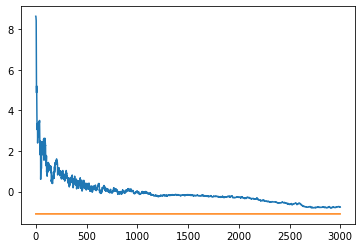

In [396]:
import matplotlib.pyplot as plt

E0 = [np.sort(e)[0] for i in range(len(out))]

El = [out[i]['E'] for i in range(len(out))]
tl = [i for i in range(len(El))]

plt.plot(tl,El)
plt.plot(tl,E0)

In [397]:
import pickle

file_to_store = open("VQE_Gunlycke_2_T"+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(t)+"_u_"+str(u)+".pickle", "wb")

pickle.dump(out, file_to_store)

In [114]:
import pickle

file_to_read = open("VQE_Gunlycke_2_T"+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(t)+"_u_"+str(u)+".pickle", "rb")

loaded_object = pickle.load(file_to_read)

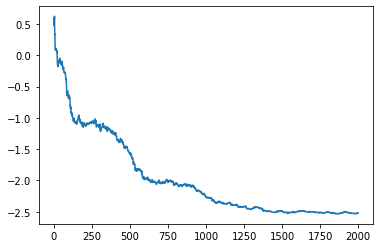

In [115]:
import matplotlib.pyplot as plt

El = [loaded_object[i]['E'] for i in range(len(loaded_object))]
tl = [i for i in range(len(El))]

plt.plot(tl,El)

In [364]:
def SPSA_from_load(k_max,method = 'simple',hold = False):
    #Initalization
    k = 0
    #alpha = 0.602
    alpha = 0.201
    A = 10
    a = 0.6
    gamma = 0.101
    c = 0.4
    phi_k = np.array(phi)
    E_l = []
    hold_l = []
    
    #Begin Iterations
    for k in range(k_max):
        #Update c and a
        a_k = a/((A + k + 1)**alpha)
        c_k = c/((k + 1)**gamma)

        #Find Delta
        Delta_k = loaded_object[k]['Delta']
        
            
        #Find E    
        E_A = find_E(phi_k + c_k*Delta_k, blocks, method = method)
        E_B = find_E(phi_k - c_k*Delta_k, blocks, method = method)
        
        #Calculate gradiant
        g = np.real((E_A-E_B)/(2*c_k)) 
        g_k = g * Delta_k
        phi_k = phi_k - a_k * g_k

        
        #Calculate new E
        E_f = np.real(find_E(phi_k, blocks, method = method))
        
        #Print and save E
        print('k=',k,'c_k=',c_k,'a_k=',a_k,'g=',g,'E_A=',E_A,'E_B=',E_B,'E_f=',E_f)
        E_l.append(E_f)
        
        if hold == True:
            hold_k = {'E':E_f,'c':c_k,'a':a_k,'phi':phi_k,'Delta':Delta_k}
            hold_l.append(hold_k)
    if hold == True:
        return hold_l
    else:
        return E_l,phi_k

In [365]:
El,psi_f = SPSA_from_load(500,method = 'simple',hold = False)

k= 0 c_k= 0.4 a_k= 0.37053677789517936 g= 0.31221237166560845 E_A= (0.6483890629959139+0j) E_B= (0.39861916566342714+0j) E_f= -0.2941674404659663
k= 1 c_k= 0.372954594574733 a_k= 0.36411269399518237 g= -0.26600035420340845 E_A= (0.2901614058922417+0j) E_B= (0.48857351440957686+0j) E_f= -0.2754518896460993
k= 2 c_k= 0.3579898757427053 a_k= 0.35830150846605 g= -0.23292677706300263 E_A= (0.29719469765243134+0j) E_B= (0.4639655536082976+0j) E_f= -0.2587121931480509
k= 3 c_k= 0.34773782403600867 a_k= 0.3530039095073033 g= 0.21234021146877308 E_A= (0.4327031217365752+0j) E_B= (0.28502567555358105+0j) E_f= -0.2459624290385531
k= 4 c_k= 0.33998833831625347 a_k= 0.3481423907099719 g= -0.8282619743549222 E_A= (0.03284742681671075+0j) E_B= (0.5960462515196494+0j) E_f= -0.08100027444187621
k= 5 c_k= 0.3337849224236992 a_k= 0.3436553693939271 g= -0.7447356728411818 E_A= (0.2115041071735653+0j) E_B= (0.7086671847444759+0j) E_f= 0.038152202417291815
k= 6 c_k= 0.32862839767254015 a_k= 0.33949315101716

k= 52 c_k= 0.267860162826851 a_k= 0.2609058398079971 g= -0.6637781002455034 E_A= (-1.0971474553042815+0j) E_B= (-0.7415480352789647+0j) E_f= -1.0994263698402225
k= 53 c_k= 0.26735494522142605 a_k= 0.26008126905440593 g= 1.407911354082114 E_A= (-0.5476712911724904+0j) E_B= (-1.3004954170669851+0j) E_f= -1.2750908604996083
k= 54 c_k= 0.2668599250350944 a_k= 0.2592720285936403 g= 0.3115613639478683 E_A= (-1.0104499459650993+0j) E_B= (-1.176736430419019+0j) E_f= -1.2814667599546898
k= 55 c_k= 0.26637471655715955 a_k= 0.25847760404433856 g= 0.1171148371603351 E_A= (-1.027592537004671+0j) E_B= (-1.0899854001111153+0j) E_f= -1.2818743830349033
k= 56 c_k= 0.2658989552298248 a_k= 0.2576975057492954 g= 0.5293579784046106 E_A= (-0.8792011062133299+0j) E_B= (-1.1607125730140462+0j) E_f= -1.282086350580811
k= 57 c_k= 0.26543229614067565 a_k= 0.2569312672388709 g= -0.139467602267511 E_A= (-1.0908689506251905+0j) E_B= (-1.0168305388109906+0j) E_f= -1.2801628270984842
k= 58 c_k= 0.26497441264651617 a_

k= 103 c_k= 0.25023014297472496 a_k= 0.23158657254318332 g= 0.16197514333165727 E_A= (-1.5241987206105965+0j) E_B= (-1.6052608471590608+0j) E_f= -1.7613944770531855
k= 104 c_k= 0.24998840873867942 a_k= 0.23118038596666274 g= -0.10559690922187386 E_A= (-1.610454788001996+0j) E_B= (-1.5576587813937979+0j) E_f= -1.76175682998874
k= 105 c_k= 0.24974919607452548 a_k= 0.2307784194017882 g= 0.23095575564585205 E_A= (-1.5114396716308858+0j) E_B= (-1.626801700233558+0j) E_f= -1.7663220086037088
k= 106 c_k= 0.2495124552599996 a_k= 0.23038059318858709 g= 0.35943278297641235 E_A= (-1.4573368947696406+0j) E_B= (-1.636702807132399+0j) E_f= -1.7735644700799984
k= 107 c_k= 0.24927813800651724 a_k= 0.22998682983541768 g= 0.3459481684476991 E_A= (-1.506252183827228+0j) E_B= (-1.6787268143820429+0j) E_f= -1.781116290224153
k= 108 c_k= 0.24904619740500722 a_k= 0.22959705394216187 g= -0.07873932143333032 E_A= (-1.6728575169562512+0j) E_B= (-1.6336380597778082+0j) E_f= -1.7823494830513171
k= 109 c_k= 0.2488

k= 153 c_k= 0.24050294487280224 a_k= 0.21526213181371276 g= 0.008744785336365263 E_A= (-1.7012406417363366+0j) E_B= (-1.7054469349876893+0j) E_f= -1.8713081976727461
k= 154 c_k= 0.24034577371294386 a_k= 0.2149992661706627 g= 0.22835649338188035 E_A= (-1.6435933200044097+0j) E_B= (-1.7533623561728953+0j) E_f= -1.8746302585197436
k= 155 c_k= 0.2401897150315199 a_k= 0.2147383069429348 g= -0.11426817501444562 E_A= (-1.7170791951622109+0j) E_B= (-1.6621871143744278+0j) E_f= -1.8751852786255994
k= 156 c_k= 0.24003475389827156 a_k= 0.21447922894421484 g= -0.28188096762304243 E_A= (-1.780900692284657+0j) E_B= (-1.6455782349006498+0j) E_f= -1.8829435060946635
k= 157 c_k= 0.23988087567680955 a_k= 0.21422200746922634 g= -0.1585448649172057 E_A= (-1.6936271332024946+0j) E_B= (-1.617563371141693+0j) E_f= -1.884116907322624
k= 158 c_k= 0.239728066017013 a_k= 0.21396661828174487 g= -0.16711155153215504 E_A= (-1.7323649605872646+0j) E_B= (-1.6522423024714528+0j) E_f= -1.8846123935717023
k= 159 c_k= 0.

k= 203 c_k= 0.23376922896323718 a_k= 0.20405069669827428 g= 0.13578834536009146 E_A= (-1.6945963510230346+0j) E_B= (-1.7580826246170793+0j) E_f= -1.9496523984210854
k= 204 c_k= 0.23365380153244633 a_k= 0.2038595775662753 g= -0.055417386332366134 E_A= (-1.7638914421314666+0j) E_B= (-1.7379944761563675+0j) E_f= -1.950437165964479
k= 205 c_k= 0.23353899237344763 a_k= 0.20366952306447533 g= -0.11792461007270193 E_A= (-1.795947970823381+0j) E_B= (-1.74086798159856+0j) E_f= -1.9518037972365203
k= 206 c_k= 0.23342479519724088 a_k= 0.20348052237451628 g= -0.09071368922306194 E_A= (-1.6991096595159274+0j) E_B= (-1.6567600108589686+0j) E_f= -1.9520031840421188
k= 207 c_k= 0.23331120380879006 a_k= 0.20329256483718383 g= 0.0483423105819938 E_A= (-1.7528395583647574+0j) E_B= (-1.7753971637183241+0j) E_f= -1.9525761027164394
k= 208 c_k= 0.2331982121051757 a_k= 0.20310563994934921 g= -0.0935832220514162 E_A= (-1.7761447814022004+0j) E_B= (-1.7324979012713366+0j) E_f= -1.9536927717094683
k= 209 c_k= 0

k= 253 c_k= 0.22865030548461726 a_k= 0.19561802104402623 g= 0.0493258290739389 E_A= (-1.7798753465321824+0j) E_B= (-1.8024320783042587+0j) E_f= -1.9759434919769092
k= 254 c_k= 0.22855958199258958 a_k= 0.19546942243156754 g= -0.057220595838998106 E_A= (-1.798263763672948+0j) E_B= (-1.7721071327402913+0j) E_f= -1.9763447043090334
k= 255 c_k= 0.22846924936970905 a_k= 0.19532149575799884 g= 0.05709263782042086 E_A= (-1.7882460155971356+0j) E_B= (-1.814333839811872+0j) E_f= -1.9766798247858155
k= 256 c_k= 0.22837930441497245 a_k= 0.19517423547591145 g= 0.031779577093912076 E_A= (-1.801824982732855+0j) E_B= (-1.8163405781554742+0j) E_f= -1.976889071770436
k= 257 c_k= 0.22828974396591784 a_k= 0.1950276361042541 g= 0.03729601650757049 E_A= (-1.791113483104523+0j) E_B= (-1.8081420792234468+0j) E_f= -1.9768232738242546
k= 258 c_k= 0.22820056489801344 a_k= 0.19488169222729543 g= 0.006766089520059693 E_A= (-1.820123037684761+0j) E_B= (-1.8232110885860173+0j) E_f= -1.9768788105756334
k= 259 c_k= 0.

k= 303 c_k= 0.2245379531555281 a_k= 0.1889158475879403 g= -0.019615701884670322 E_A= (-1.7602038357017515+0j) E_B= (-1.7513948965999657+0j) E_f= -1.98032834121638
k= 304 c_k= 0.22446348815402628 a_k= 0.18879514811017423 g= -0.015041963527366373 E_A= (-1.807511441626499+0j) E_B= (-1.8007586984224224+0j) E_f= -1.9804480317890927
k= 305 c_k= 0.22438929147512626 a_k= 0.1886749079481776 g= -0.005379159727201483 E_A= (-1.7702282511470542+0j) E_B= (-1.7678141994672176+0j) E_f= -1.9804321975331283
k= 306 c_k= 0.2243153612798253 a_k= 0.18855512390879003 g= -0.034871426066510405 E_A= (-1.7960331364346231+0j) E_B= (-1.7803887433617192+0j) E_f= -1.9805199722103088
k= 307 c_k= 0.2242416957476633 a_k= 0.18843579283103418 g= -0.032066339120264485 E_A= (-1.7986848505079438+0j) E_B= (-1.7843036299864483+0j) E_f= -1.980643996427383
k= 308 c_k= 0.22416829307647623 a_k= 0.1883169115856913 g= 0.016437240735645058 E_A= (-1.8042523980589036+0j) E_B= (-1.811621814456097+0j) E_f= -1.9806908605402178
k= 309 c_k

k= 353 c_k= 0.22111115942370668 a_k= 0.18338756003289805 g= 0.03882221520856018 E_A= (-1.7998008757955735+0j) E_B= (-1.8169689258278963+0j) E_f= -1.9820295317492296
k= 354 c_k= 0.2210481719458794 a_k= 0.18328646055073458 g= 0.0071509458131375405 E_A= (-1.8159274534849292+0j) E_B= (-1.8190888604842854+0j) E_f= -1.982010473015273
k= 355 c_k= 0.22098537951573047 a_k= 0.18318569318138667 g= -0.0019019534642685481 E_A= (-1.8242452398534958+0j) E_B= (-1.8234046320372506+0j) E_f= -1.9820130283647297
k= 356 c_k= 0.22092278098392504 a_k= 0.18308525593090869 g= -0.0038706887352812466 E_A= (-1.8230589603195704+0j) E_B= (-1.8213487136801274+0j) E_f= -1.981995495332018
k= 357 c_k= 0.2208603752110963 a_k= 0.1829851468227179 g= -0.02755966959595011 E_A= (-1.7940244271544605+0j) E_B= (-1.7818507492191498+0j) E_f= -1.9818850452459345
k= 358 c_k= 0.22079816106773162 a_k= 0.1828853638973968 g= -0.025775513851473135 E_A= (-1.7944604951253116+0j) E_B= (-1.7830781230073494+0j) E_f= -1.98201530577851
k= 359 

k= 403 c_k= 0.2181802692919501 a_k= 0.178703962236058 g= -0.010292584394149944 E_A= (-1.8269843762250224+0j) E_B= (-1.822493098555371+0j) E_f= -1.9821872263662588
k= 404 c_k= 0.2181257984204375 a_k= 0.17861732579176134 g= -0.01397943804524545 E_A= (-1.8192733892152475+0j) E_B= (-1.813174837045071+0j) E_f= -1.9821662925072885
k= 405 c_k= 0.2180714754281335 a_k= 0.17853093970918948 g= 0.004043741360277849 E_A= (-1.7976272361660897+0j) E_B= (-1.7993908854554608+0j) E_f= -1.9821446936108817
k= 406 c_k= 0.2180172995508166 a_k= 0.17844480266562 g= 0.005504211774597279 E_A= (-1.7852497522691575+0j) E_B= (-1.7876497790436645+0j) E_f= -1.982131343482575
k= 407 c_k= 0.21796327003008015 a_k= 0.17835891334846937 g= 0.0011722443329561072 E_A= (-1.801086633472+0j) E_B= (-1.8015976458881706+0j) E_f= -1.9821261851195617
k= 408 c_k= 0.2179093861132739 a_k= 0.1782732704551914 g= 0.00961478644325766 E_A= (-1.8063669744072754+0j) E_B= (-1.8105572788301965+0j) E_f= -1.982162633667444
k= 409 c_k= 0.21785564

k= 453 c_k= 0.2156241250645643 a_k= 0.17465504553076158 g= 0.009446685368866442 E_A= (-1.8186774143847995+0j) E_B= (-1.8227512809196436+0j) E_f= -1.9826608724809287
k= 454 c_k= 0.21557621389665993 a_k= 0.17457948453338862 g= 0.0191982866251469 E_A= (-1.8247353705263607+0j) E_B= (-1.8330127584142648+0j) E_f= -1.9827637711465338
k= 455 c_k= 0.21552841852324142 a_k= 0.17450411844306418 g= -0.011228681778111526 E_A= (-1.803329787273987+0j) E_B= (-1.7984895872225128+0j) E_f= -1.9827469403049183
k= 456 c_k= 0.21548073841143345 a_k= 0.17442894634039197 g= -0.00574623040761278 E_A= (-1.7894589045678506+0j) E_B= (-1.7869825006252213+0j) E_f= -1.9827223173735788
k= 457 c_k= 0.2154331730319722 a_k= 0.1743539673122692 g= -0.007685584631084743 E_A= (-1.8168967167008234+0j) E_B= (-1.8135852569334627+0j) E_f= -1.9826985403407287
k= 458 c_k= 0.21538572185917312 a_k= 0.1742791804518308 g= 0.0124803870127395 E_A= (-1.802406528289735+0j) E_B= (-1.8077827226213765+0j) E_f= -1.982694716952244
k= 459 c_k= 0

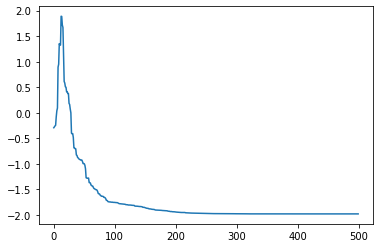

In [367]:
import matplotlib.pyplot as plt

tl = [i for i in range(len(El))]

plt.plot(tl,El)

In [30]:
pwd

'C:\\Users\\jsten\\IBMQ\\Hubbard_symmetries'